In [1]:
from PIL import Image, ImageOps
import numpy as np
import matplotlib.pyplot as plt
import random
from tabulate import tabulate

# Texture factory creates 2D checkerboards with a transparecy placed on top.
from minimal_example_contrast_metric.texture_factory import TextureFactory

# fixed parameters for the texture factory
n = 21
image_width = 480
block_width = image_width // n

In [2]:
# luminance values are in random order, they are not ordered in an ascending or descending order

bg_luminance_values = [0.000001, 0.75, 0.25, 0.5, 1.0], [0.05, 0.725, 0.275, 0.5, 0.95], [0.1, 0.7, 0.3, 0.5, 0.9], [0.15, 0.675, 0.325, 0.5, 0.85], [0.2, 0.65, 0.35, 0.5, 0.8], [0.25, 0.625, 0.375, 0.5, 0.75], [0.3, 0.6, 0.4, 0.5, 0.7], [0.35, 0.575, 0.425, 0.5, 0.65], [0.4, 0.55, 0.45, 0.5, 0.6], [0.45,0.525,0.475,0.5,0.55] 


tau_values = 0.1, 0.2, 0.5, 1.0
alpha_values = 0.1, 0.2, 0.5

images = []

for luminance in bg_luminance_values:
    f = TextureFactory('random',
                       block_width=block_width, 
                       image_width=image_width,
                       luminance_values=luminance)
    for tau in tau_values:
        for alpha in alpha_values:

            # here we ask the factory to give us different background contrasts with constant alpha and tau values.
            im = f.get_image(tau, alpha, bg_luminance=None)
            plt.figure()
            plt.imshow(im, cmap='gray', vmin=0, vmax=1)
            plt.close()

            # we need to convert array to PIL and use PIL library to save. MATPLOTLIB is not reliable when saving images
            # as it can add unwanted borders
            im = Image.fromarray(im*255).convert('L')
            # created images are added to images list
            images.append(im)

# we now have images with different background contrasts, tau and alpha values.

array size (480, 480)


array([0., 1.])

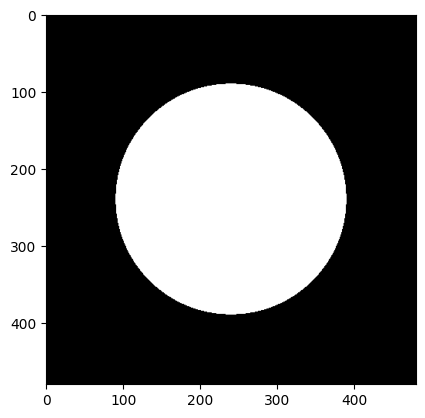

In [3]:
# creating the mask for the inner circle
# getting a checkerboard with a complete white opaque transparecy
f = TextureFactory('checkerboard',block_width=block_width, image_width=image_width,luminance_values= [0, 0, 0, 1, 1])
mask = f.get_image(1, 0, bg_luminance=0.0)

print('array size', mask.shape)
plt.figure()
plt.imshow(mask, cmap='gray', vmin=0, vmax=1)

# saving in case we need it in another notebook 
mask_im = Image.fromarray(mask*255).convert('L')
mask_im.save('mask.png')

np.unique(mask) # should be only 0 and 1 as the mask is binary

In [4]:
def to_array(i):
    
    # open images with a transparency
    ims = images[i]

    # convert to numpy array
    im = np.array(ims)
    display(Image.fromarray(im))
    


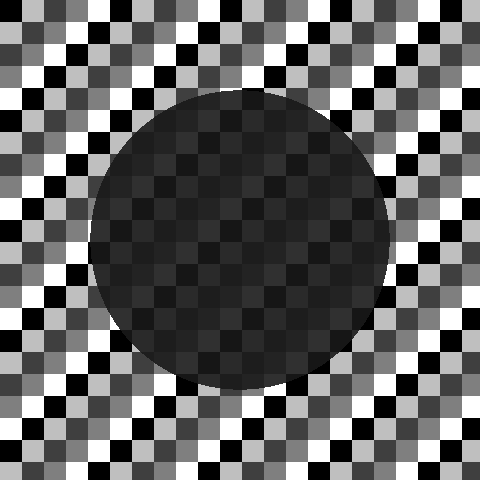

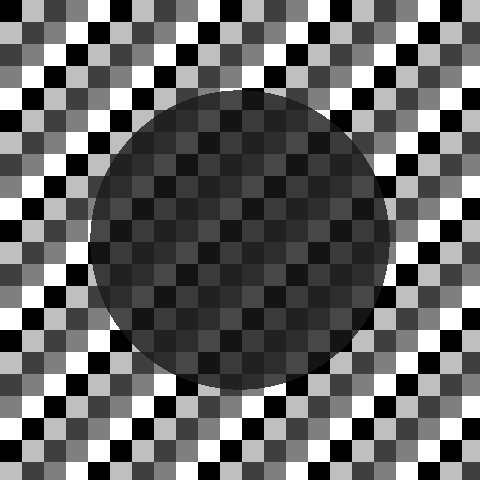

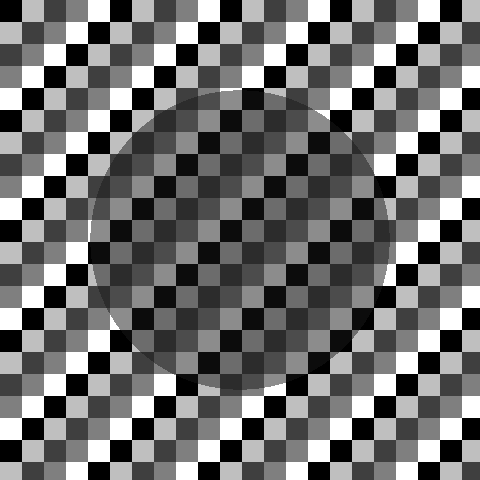

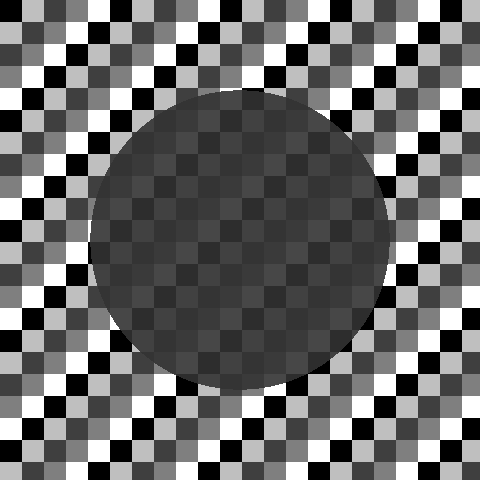

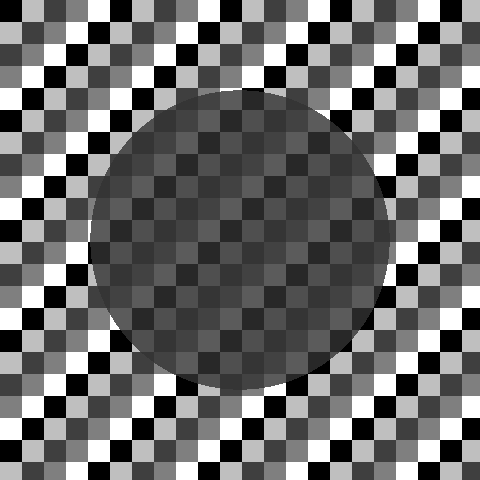

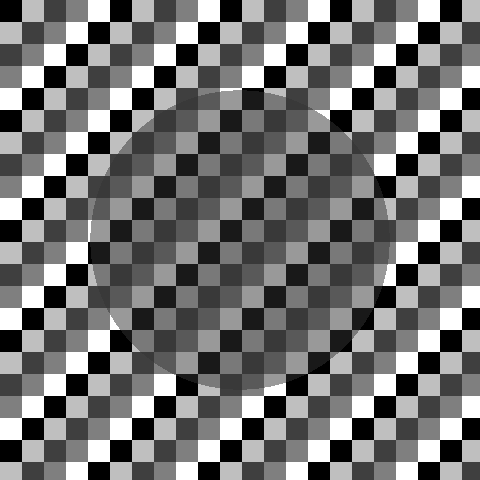

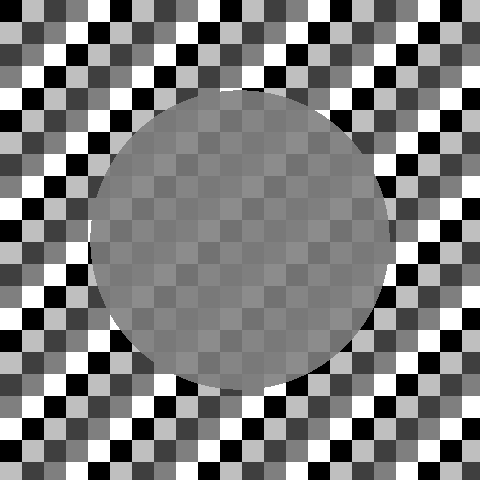

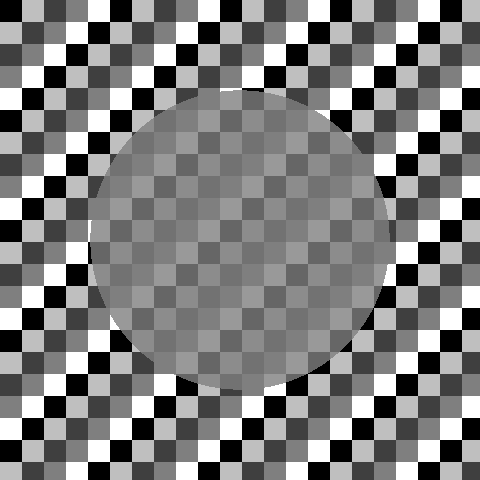

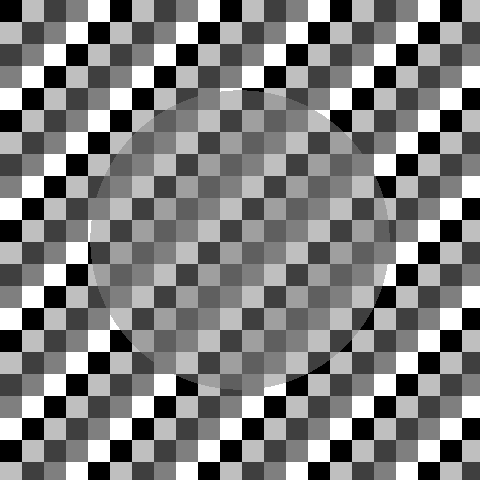

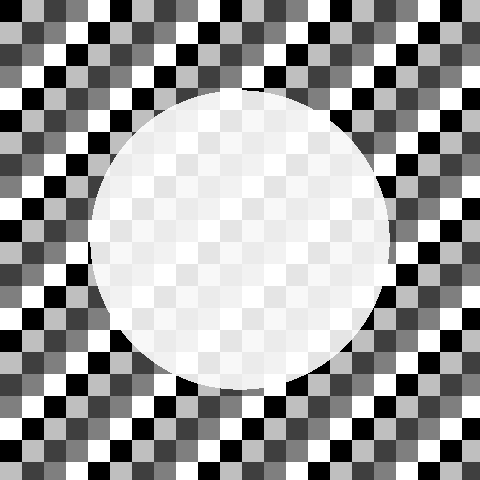

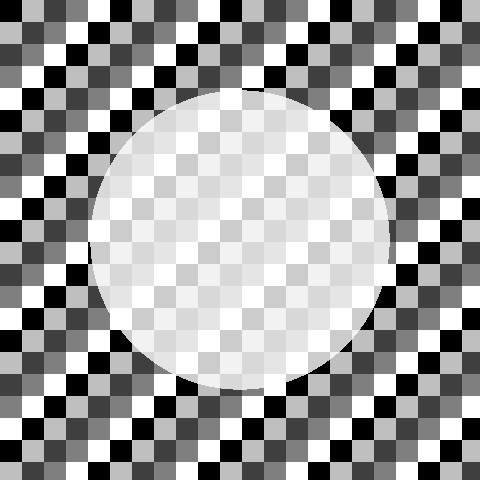

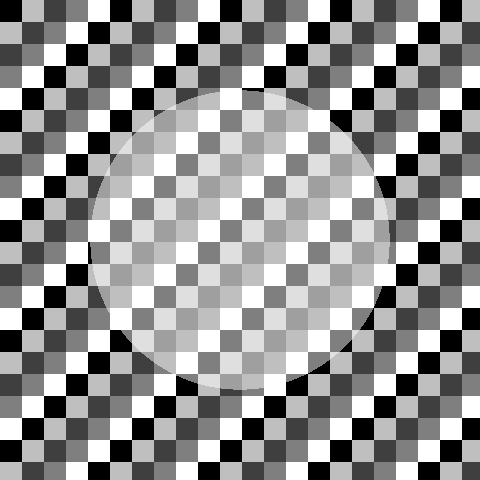

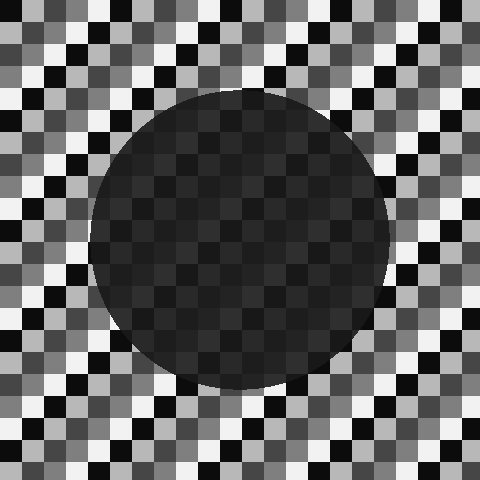

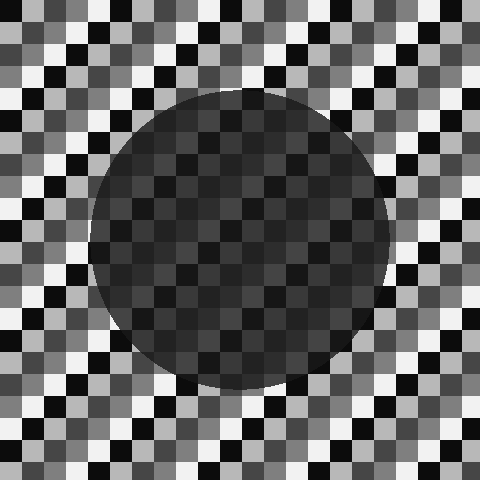

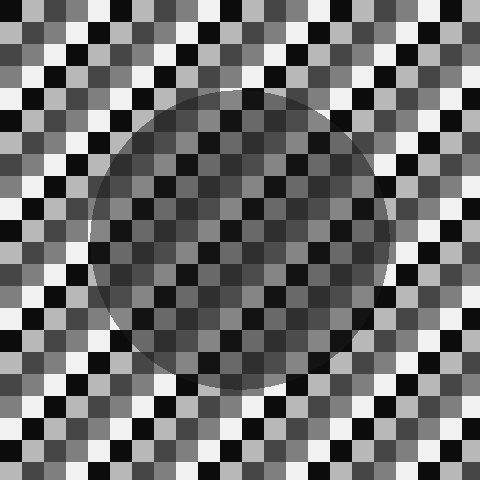

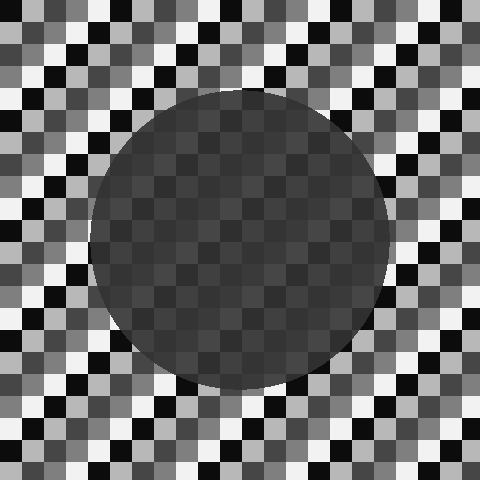

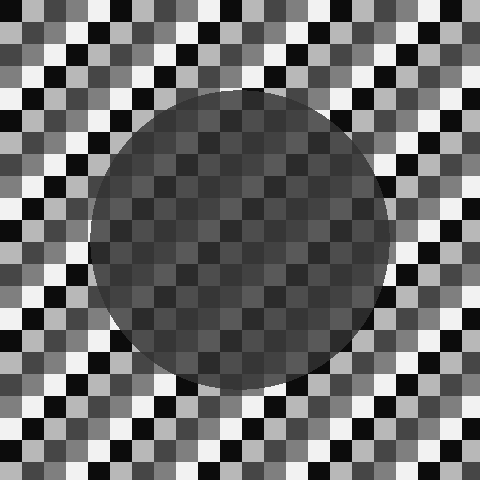

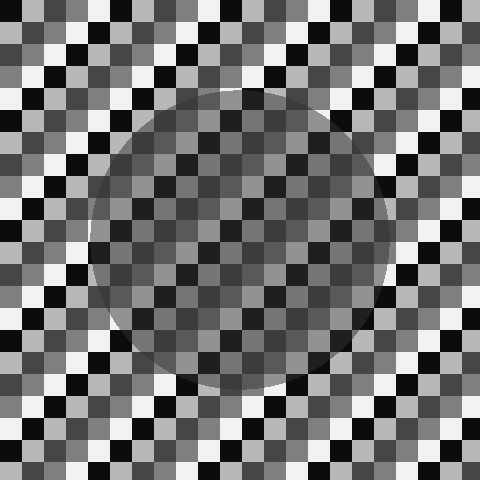

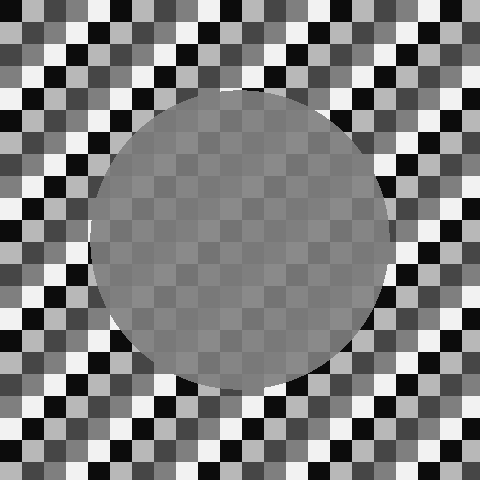

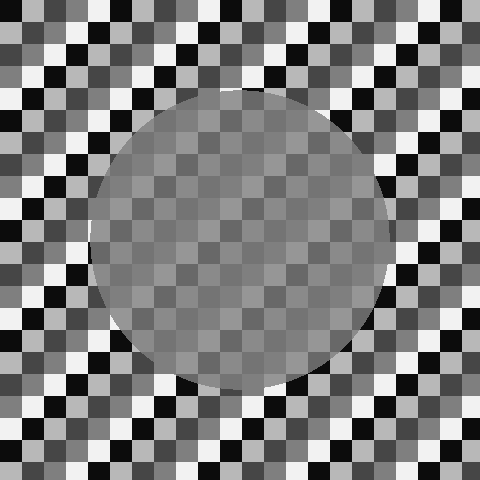

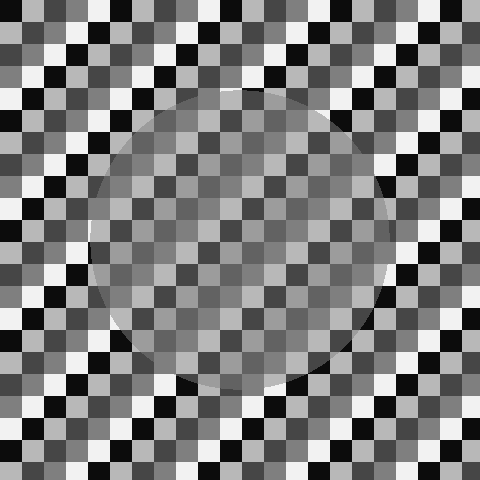

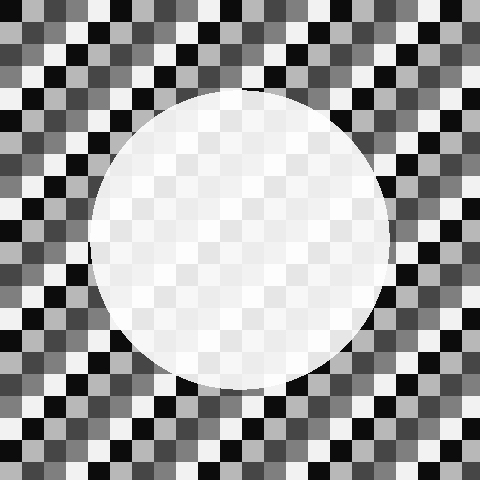

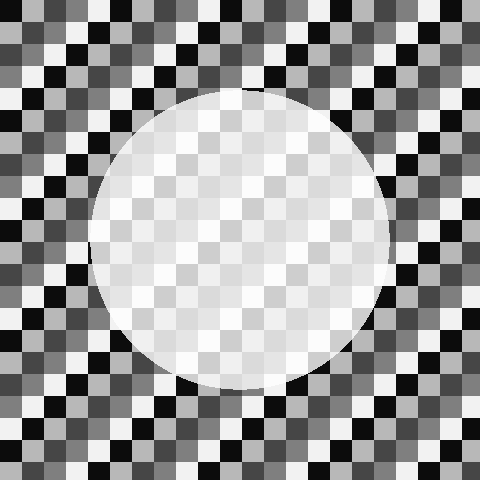

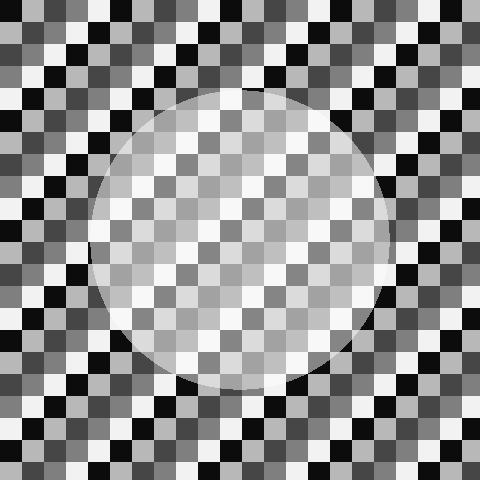

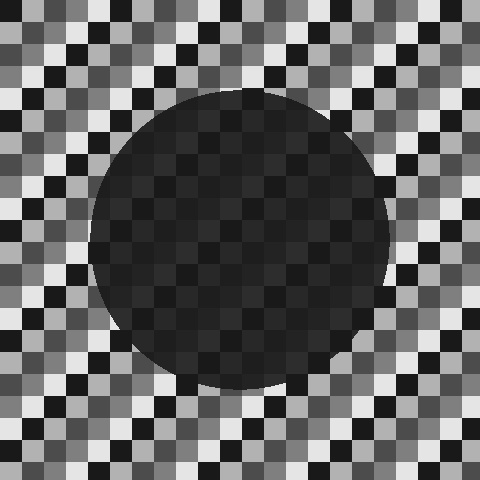

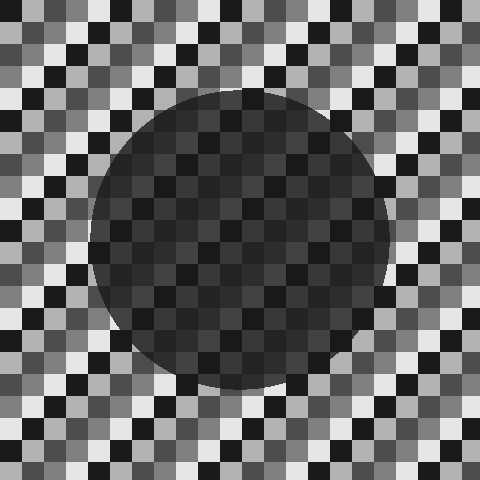

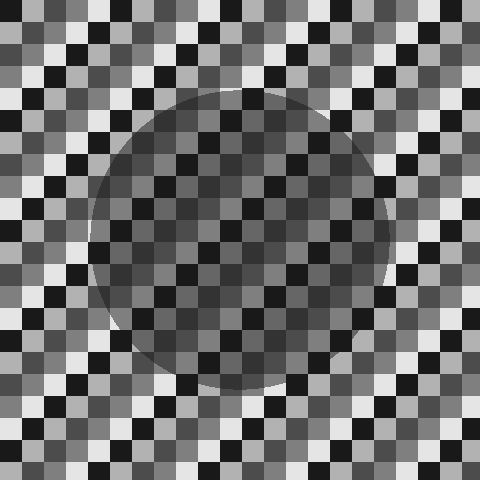

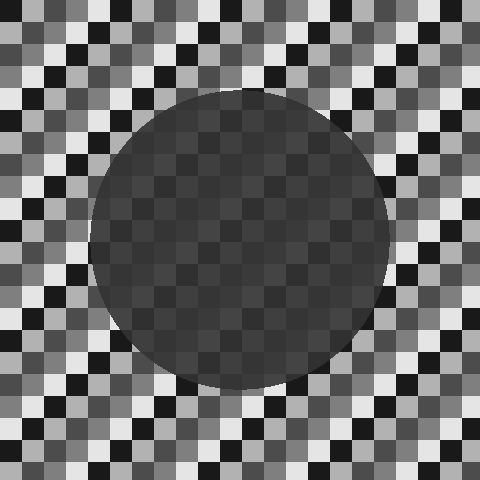

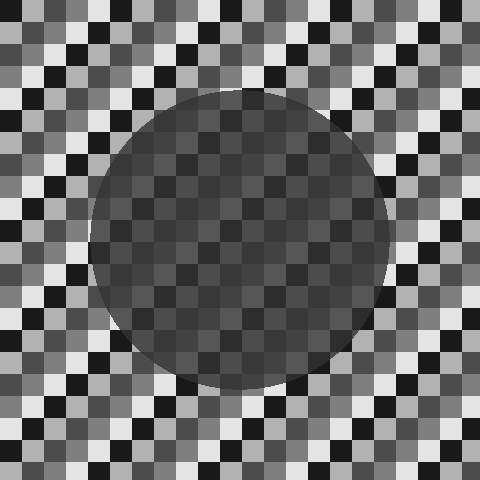

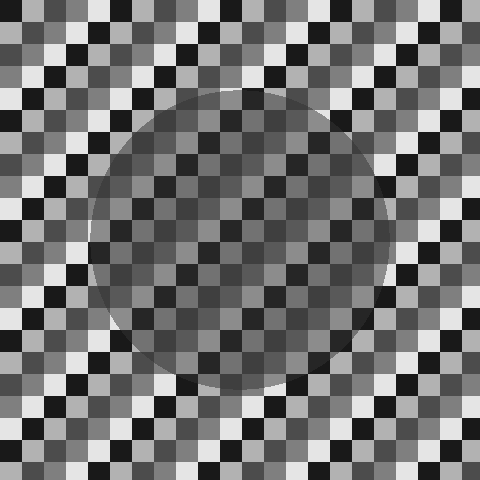

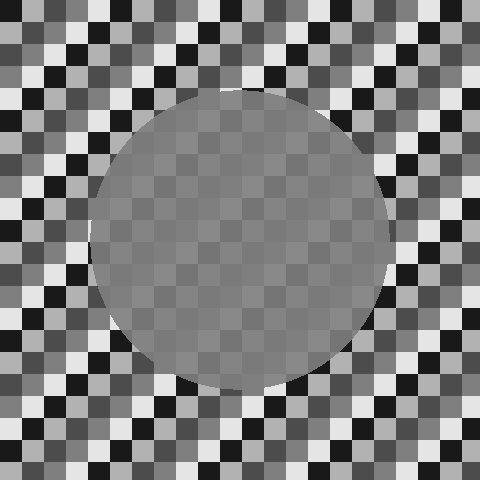

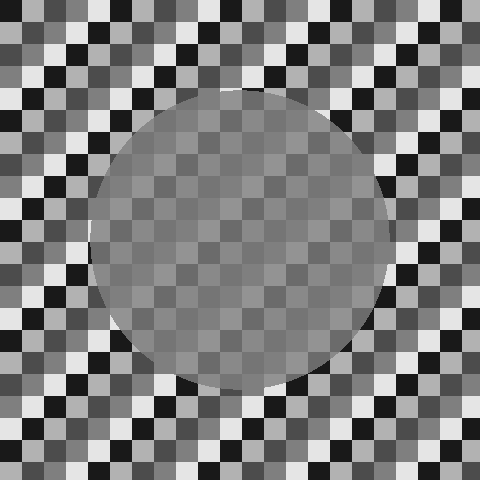

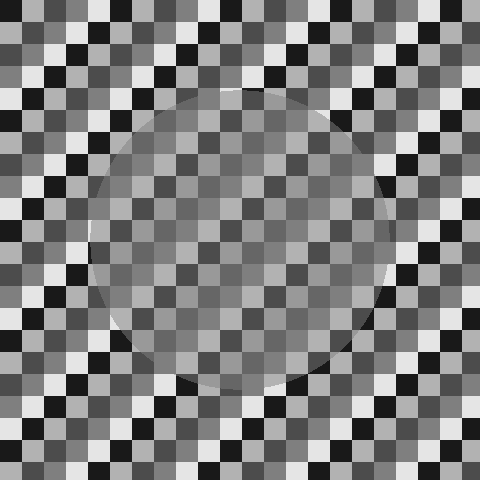

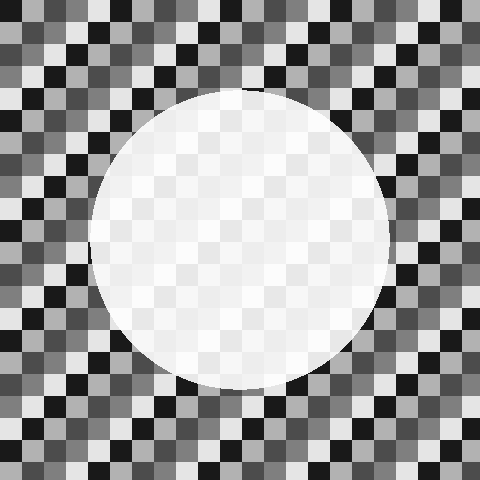

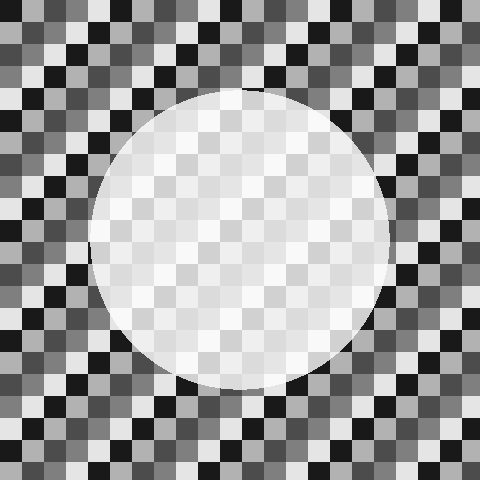

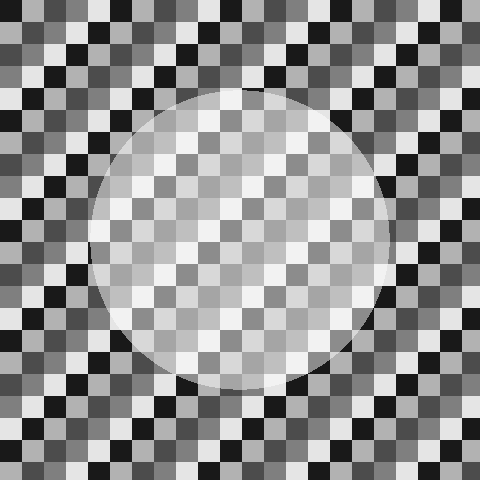

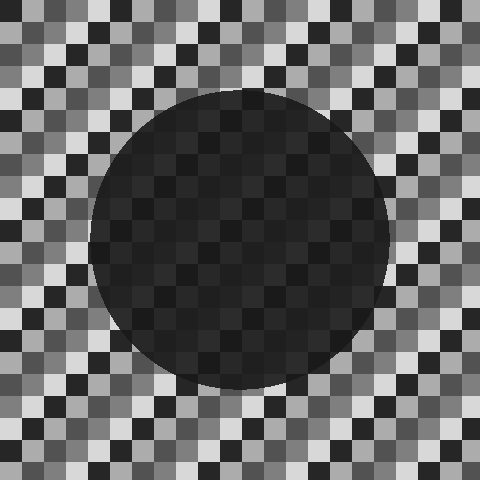

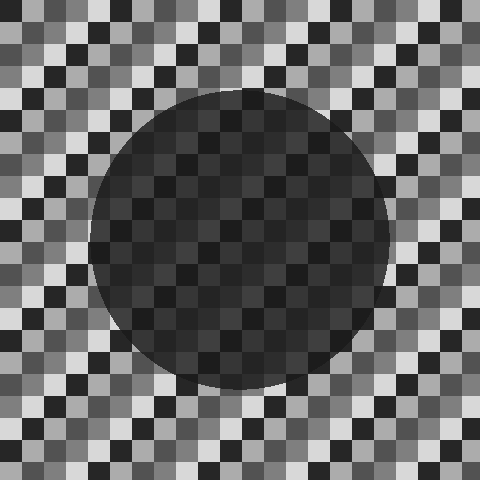

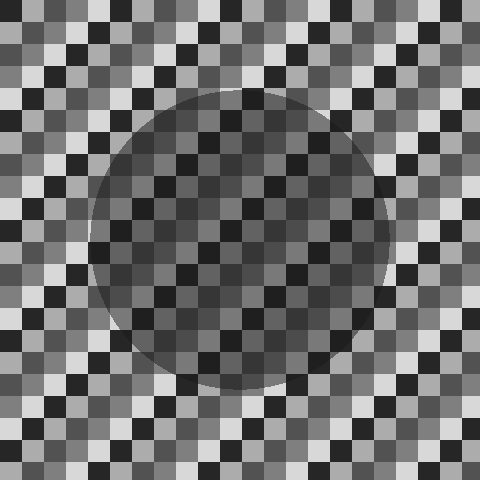

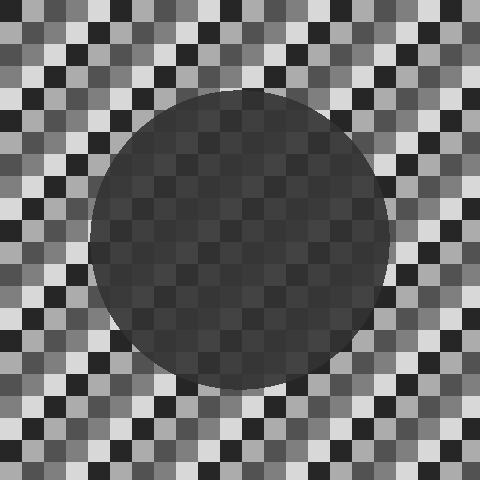

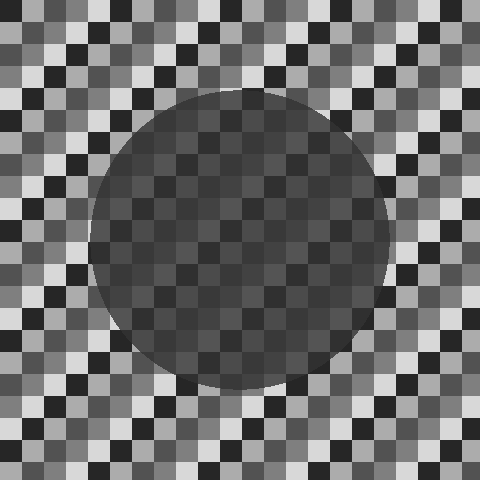

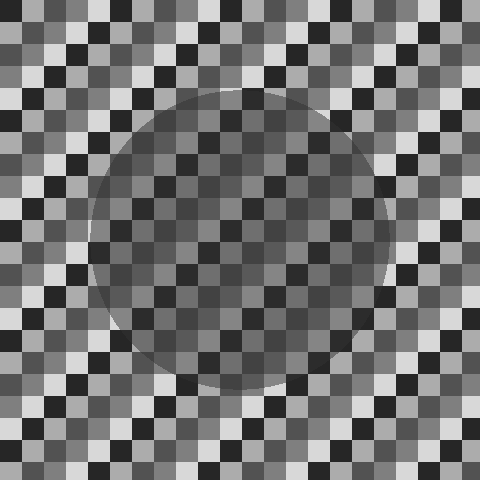

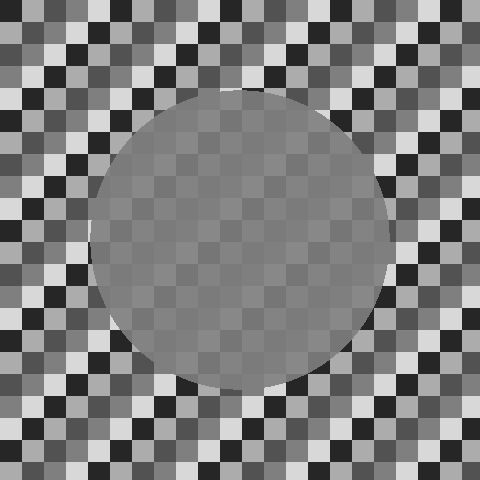

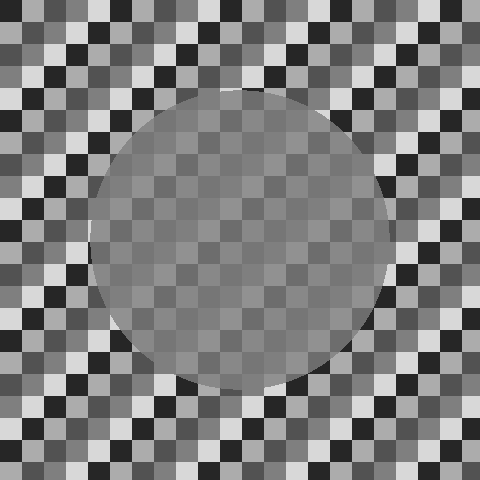

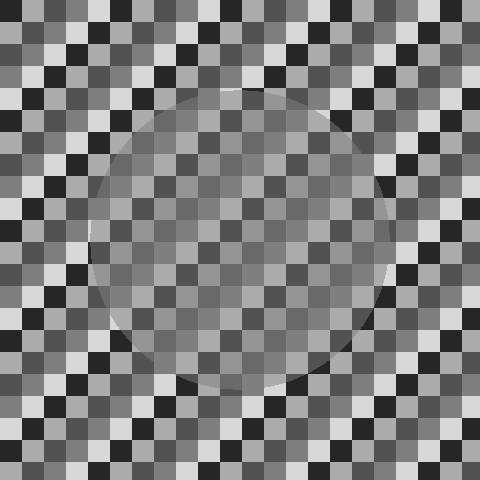

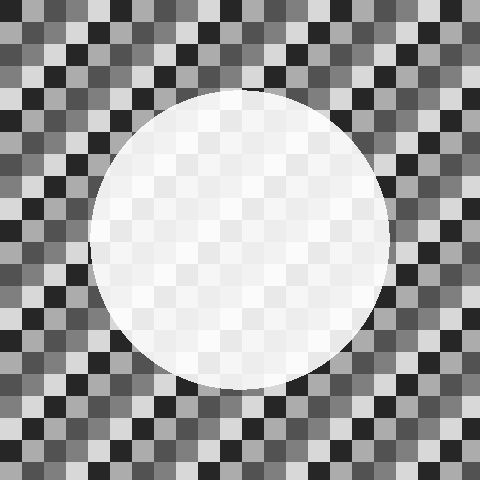

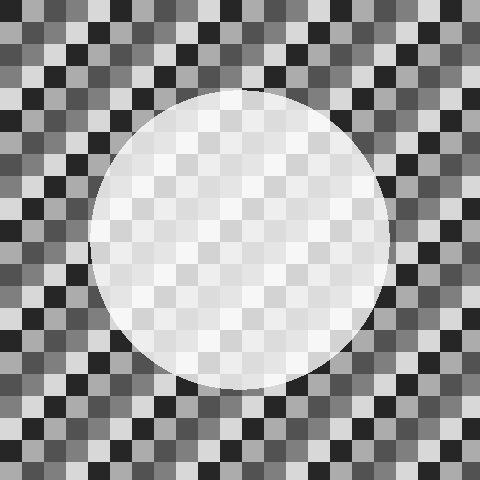

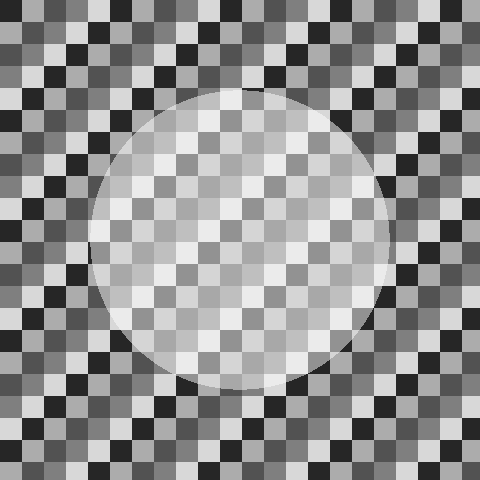

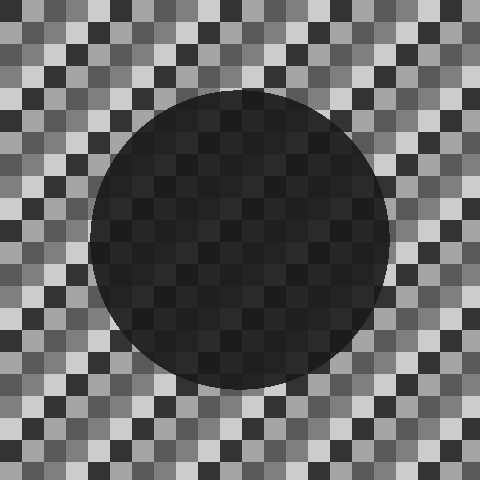

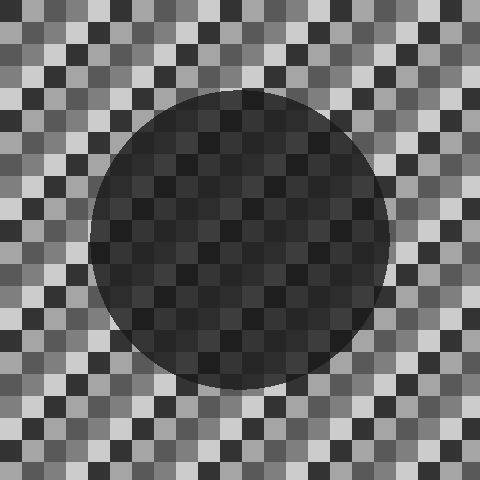

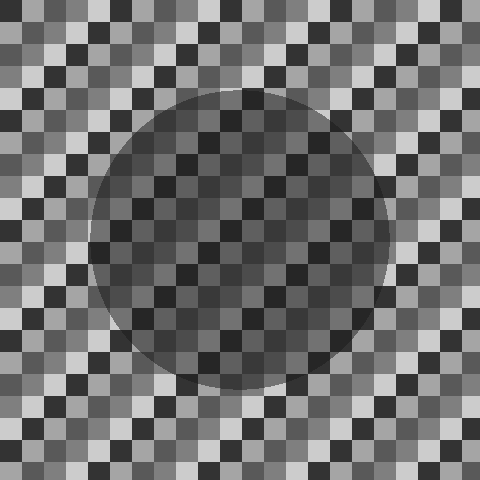

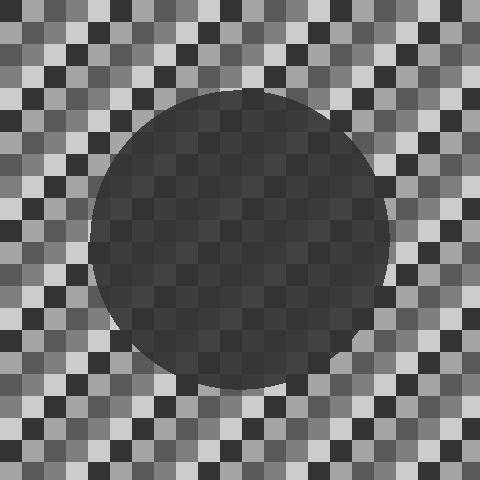

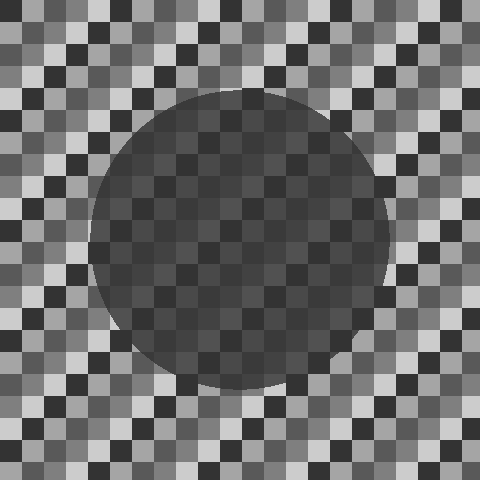

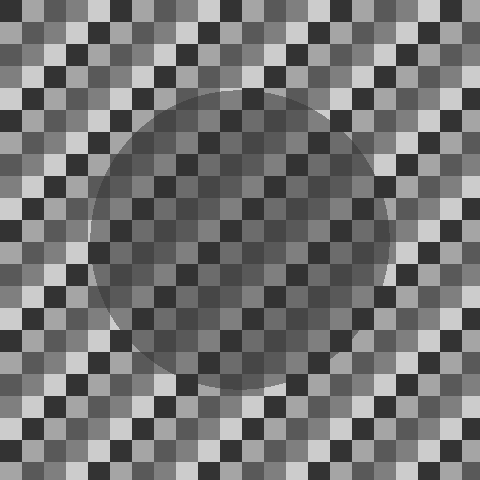

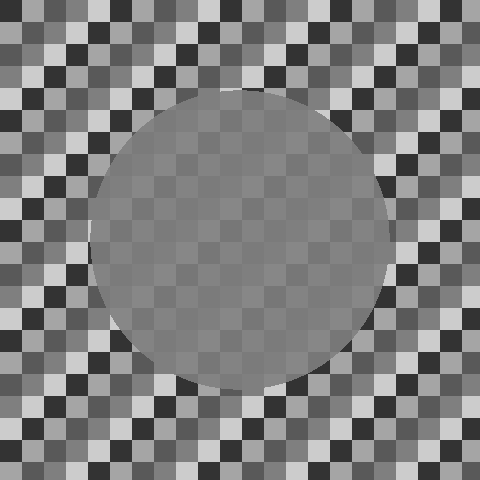

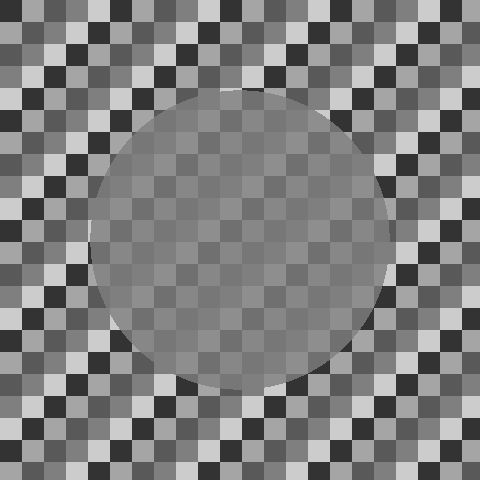

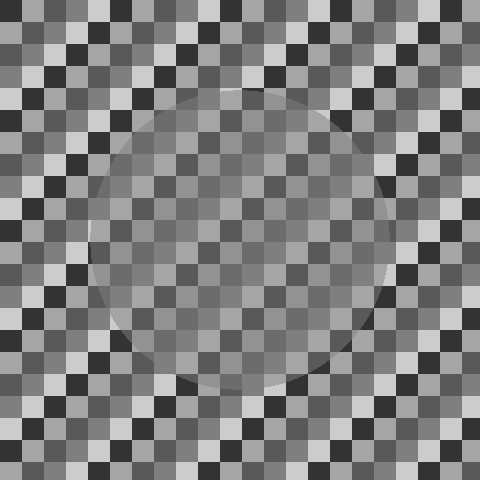

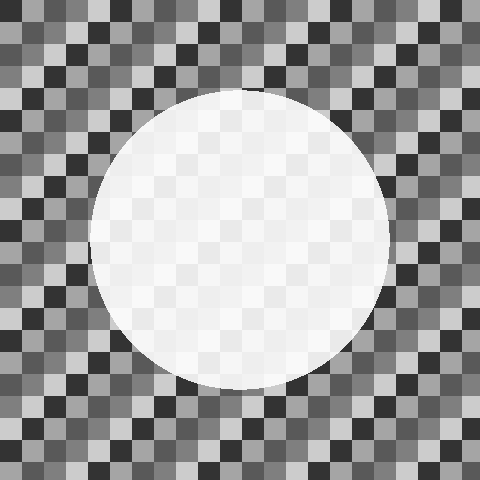

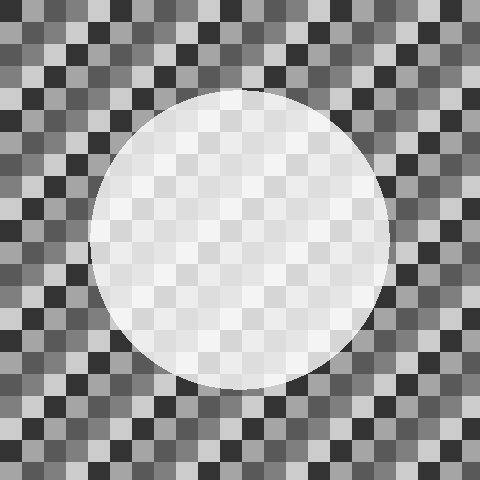

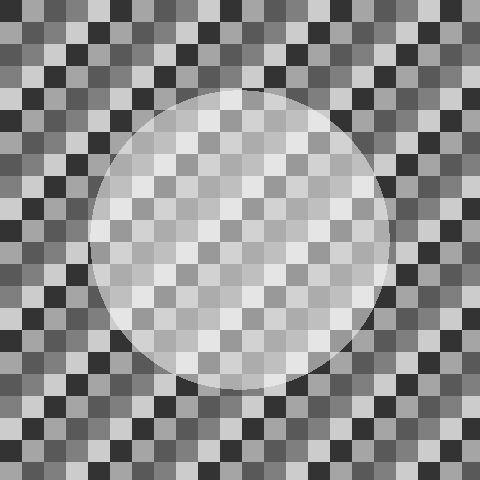

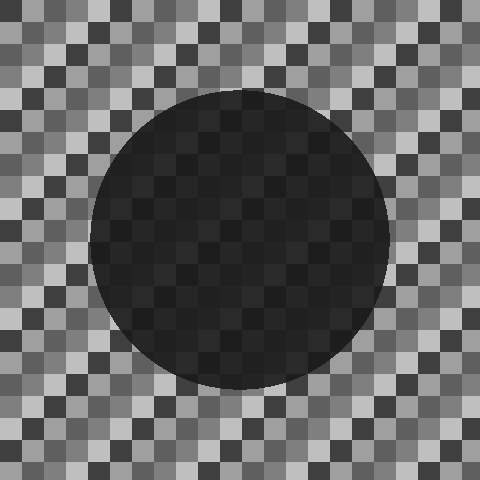

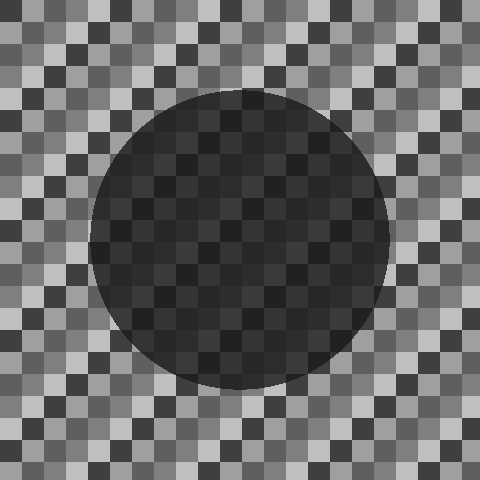

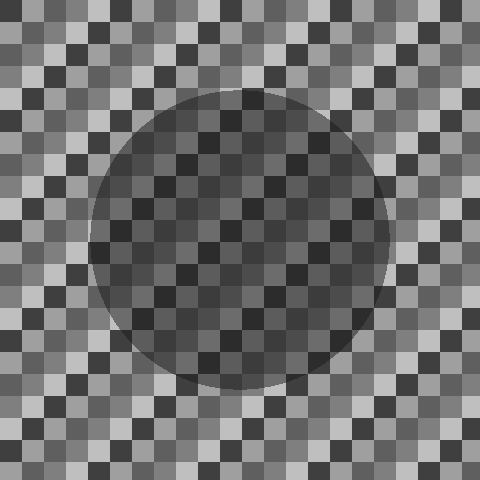

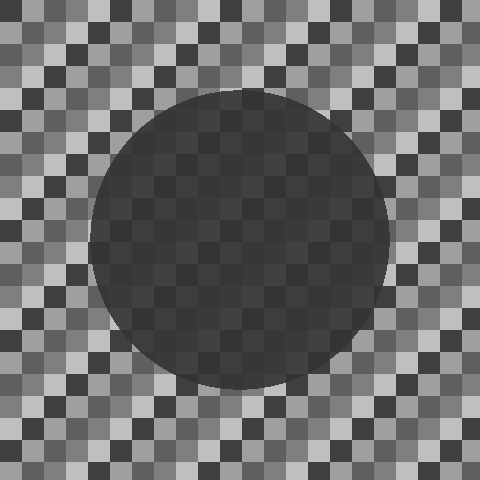

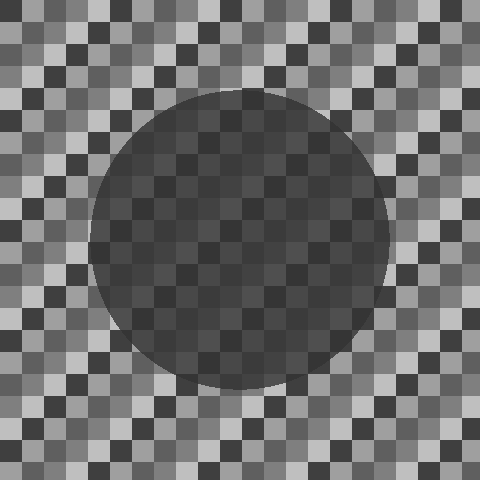

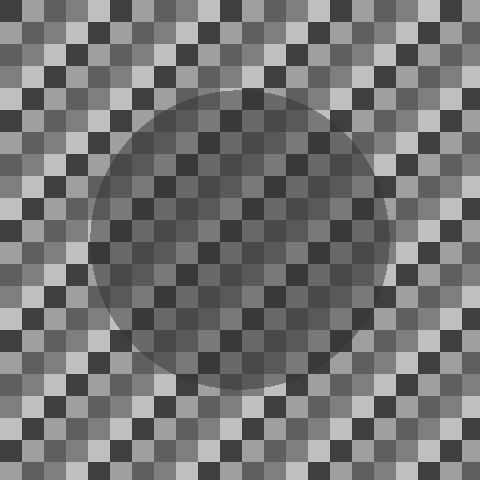

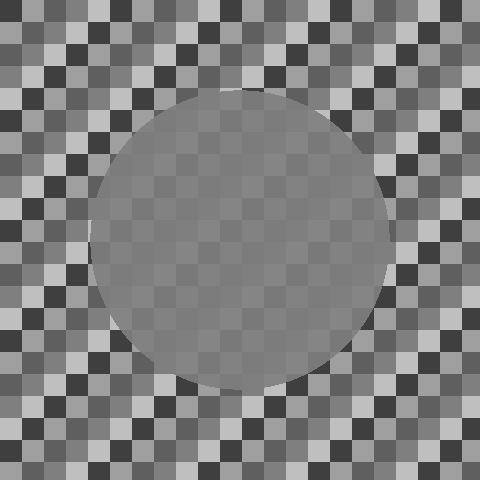

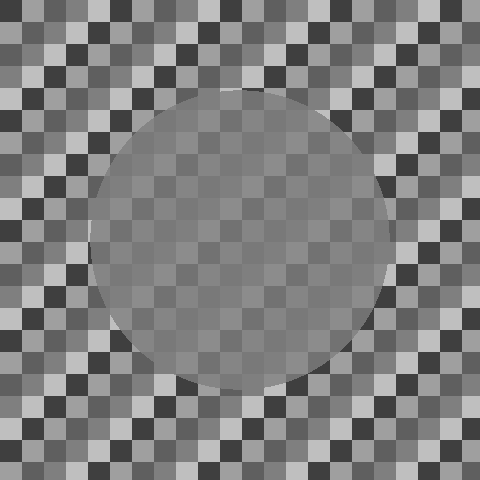

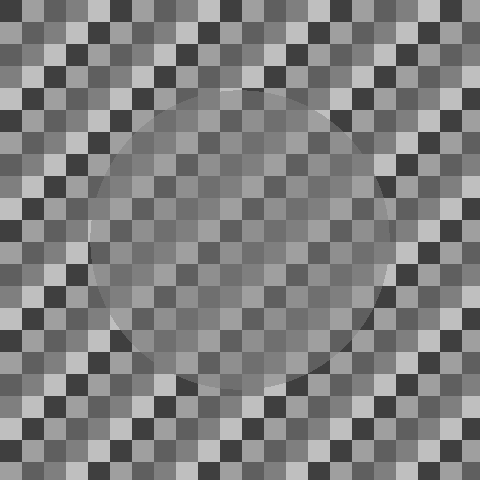

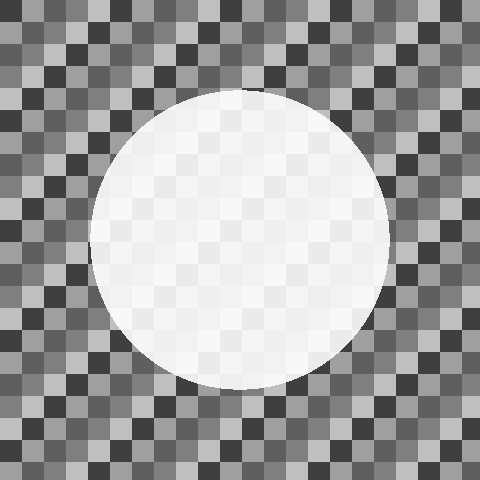

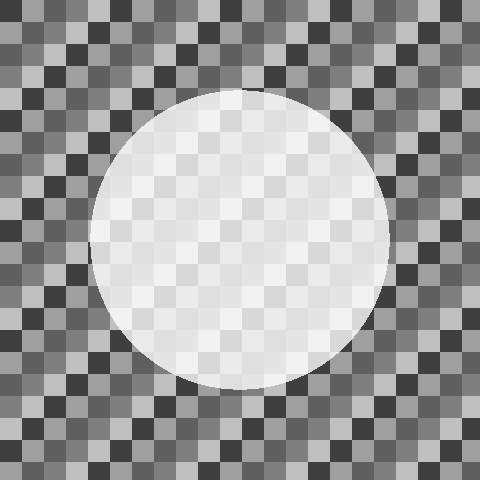

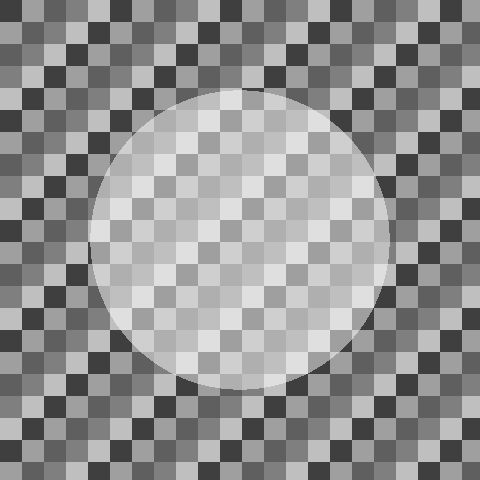

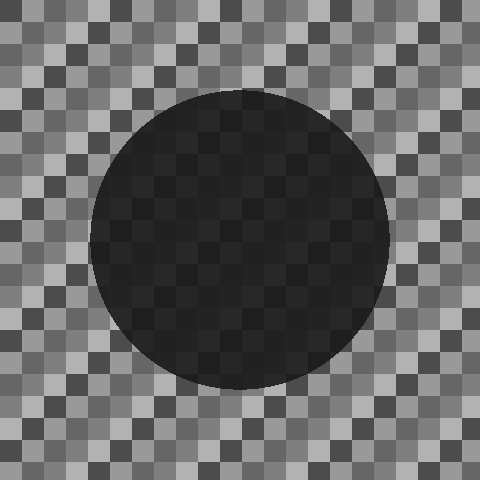

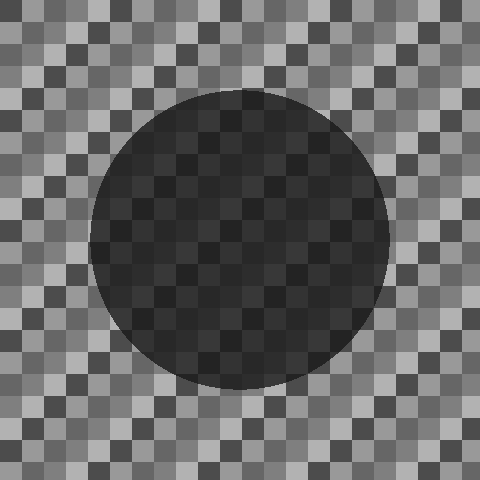

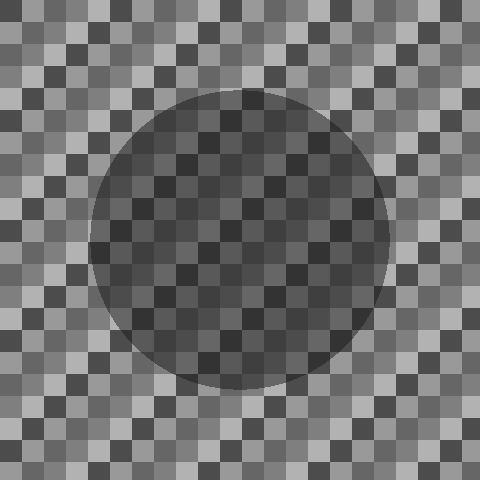

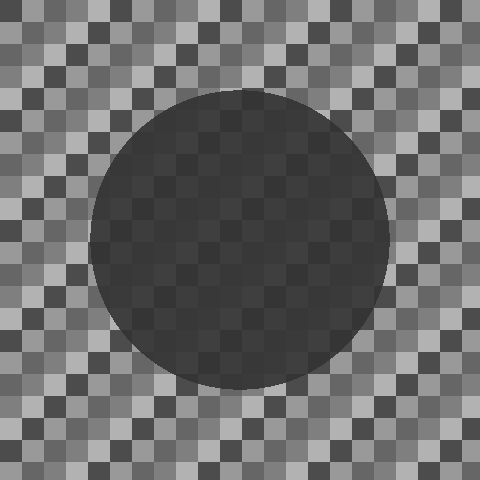

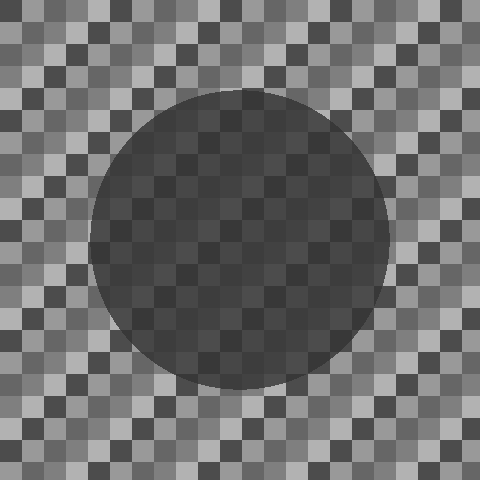

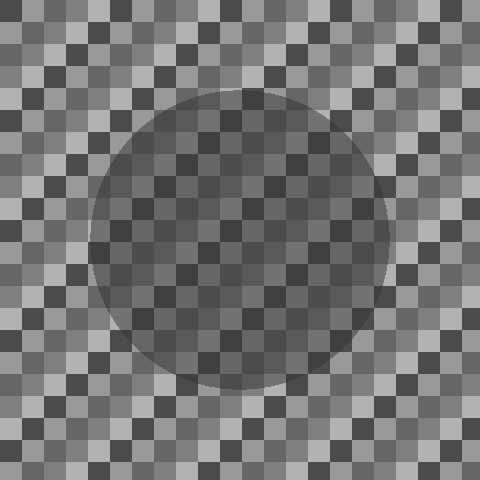

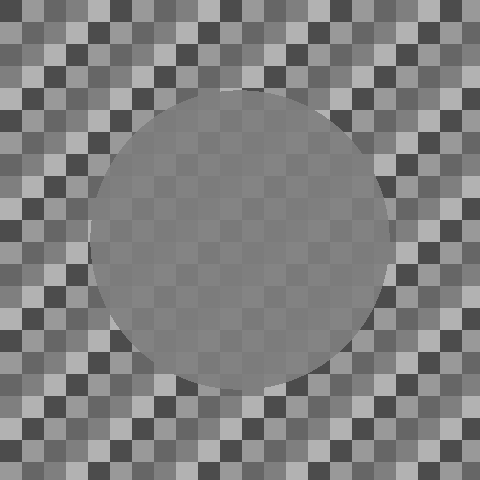

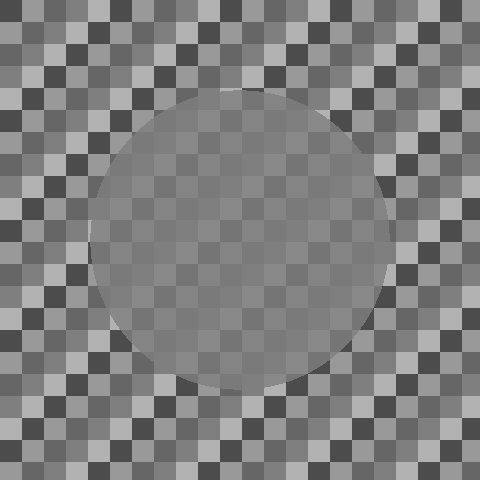

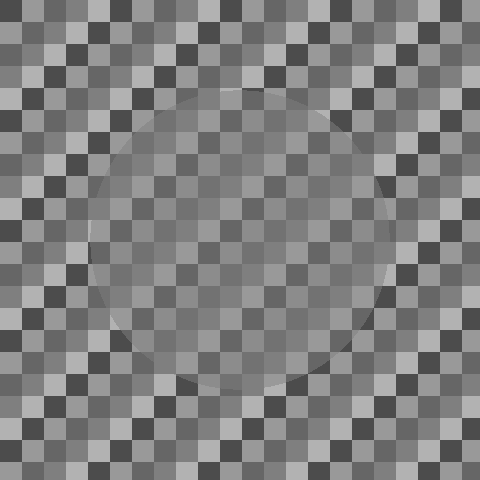

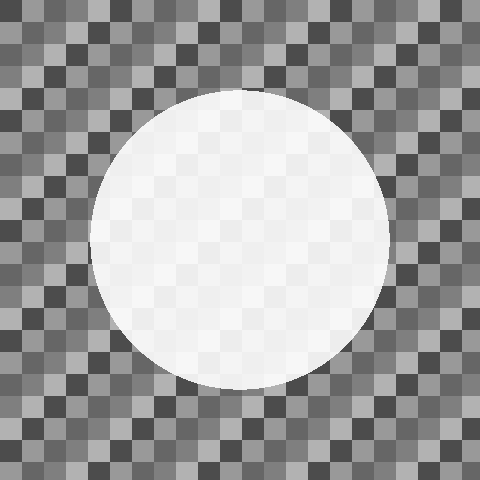

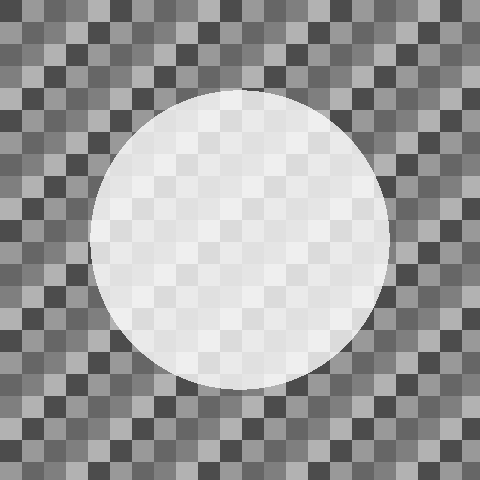

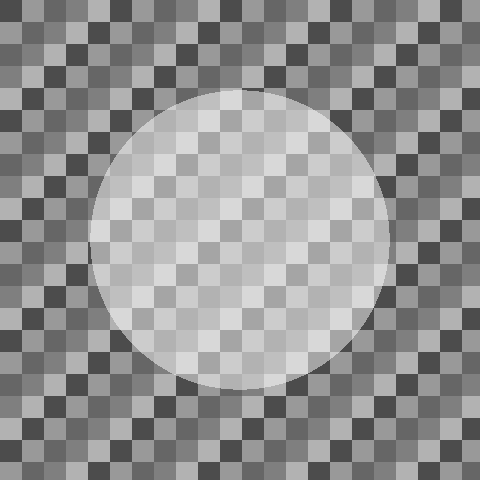

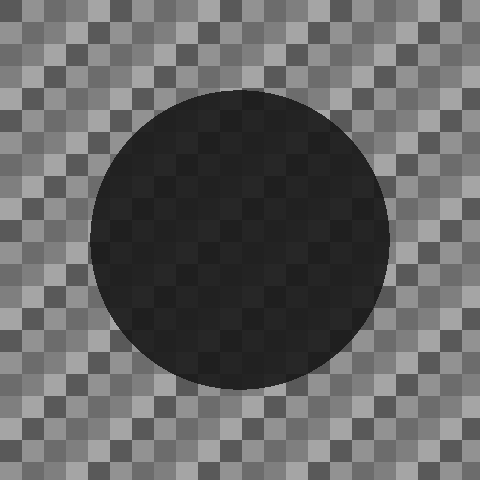

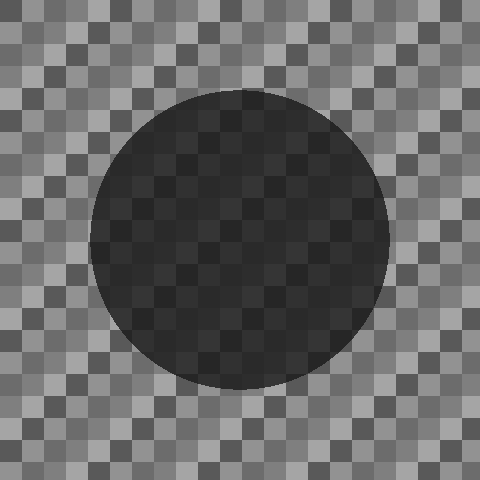

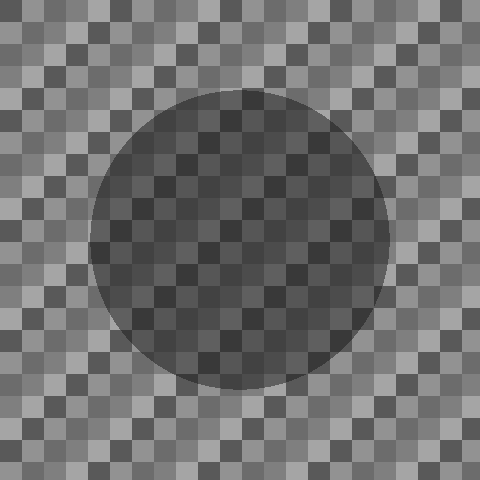

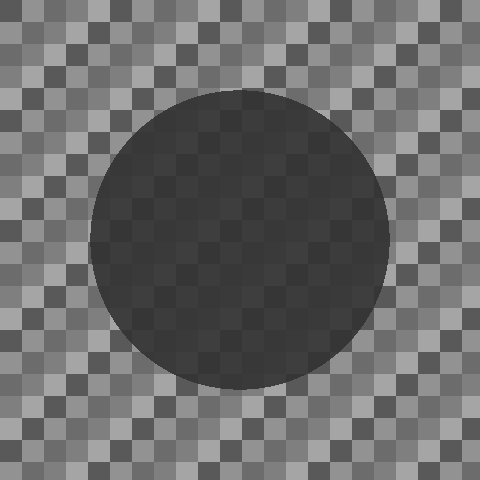

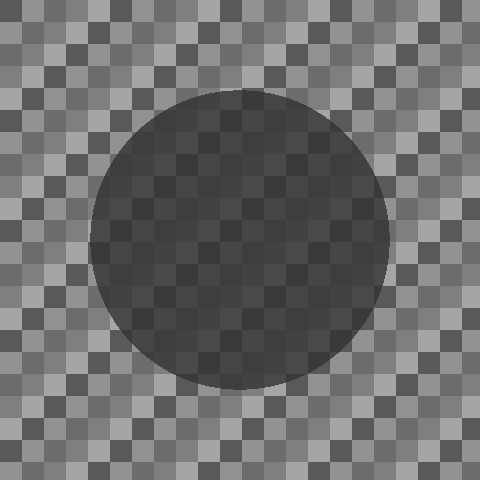

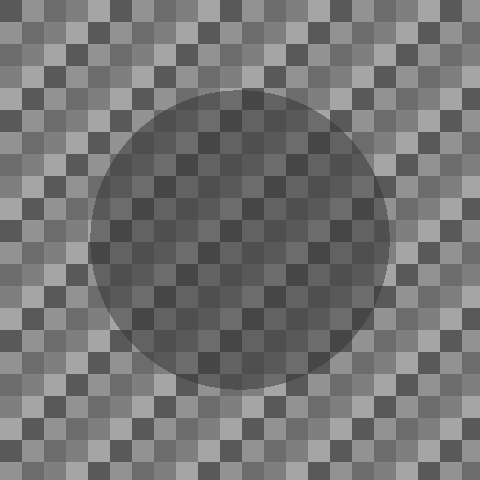

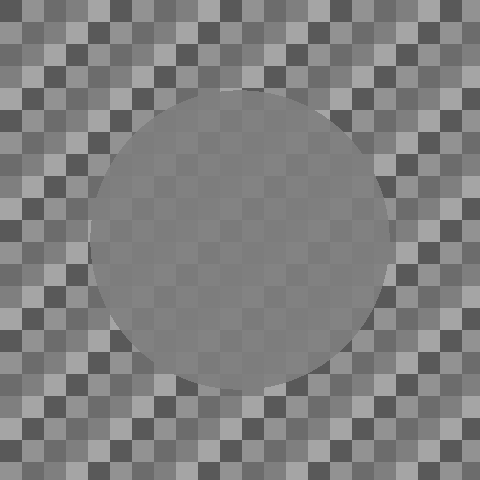

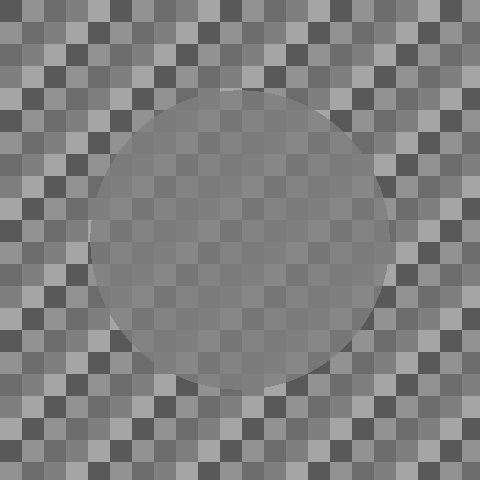

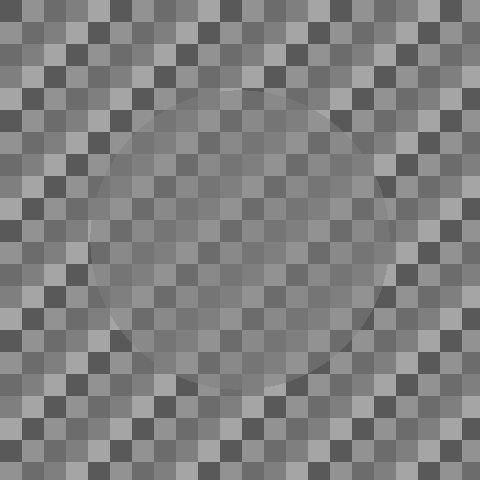

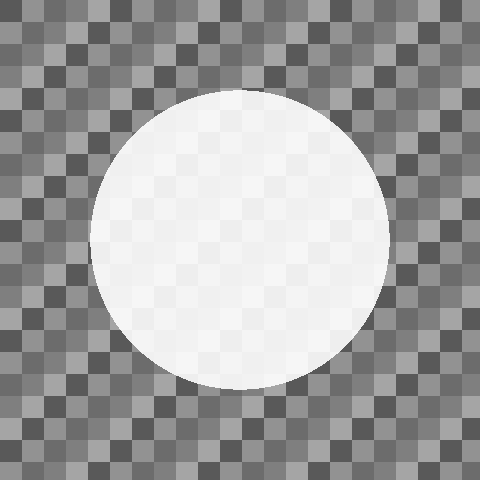

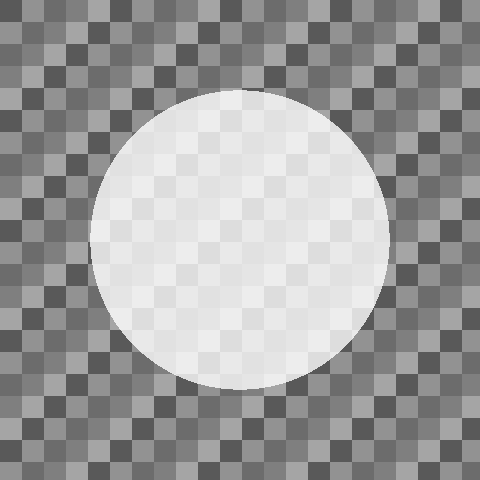

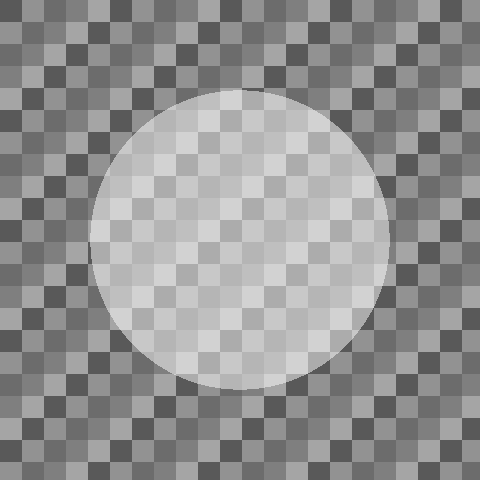

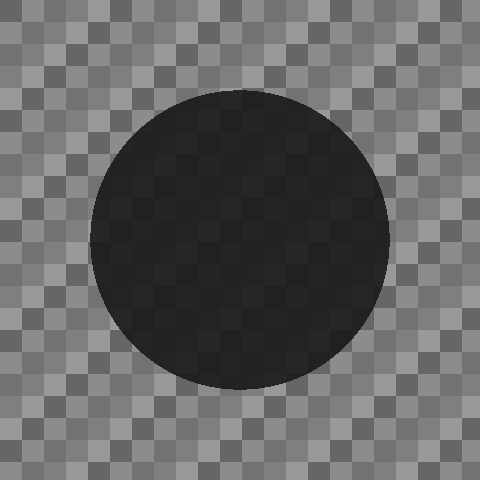

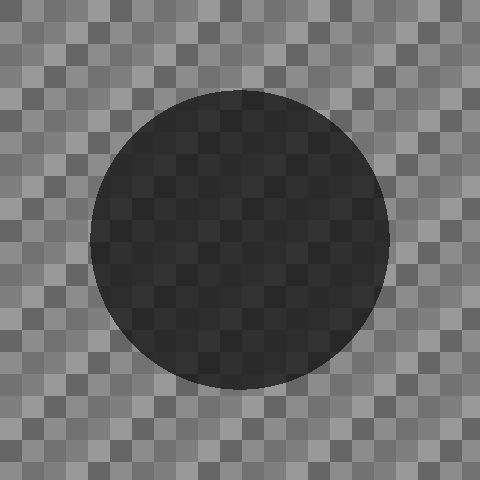

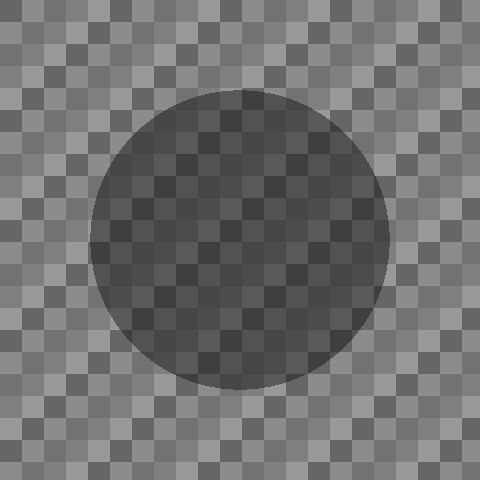

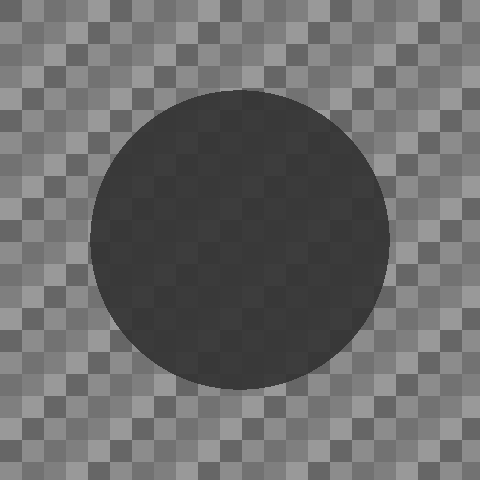

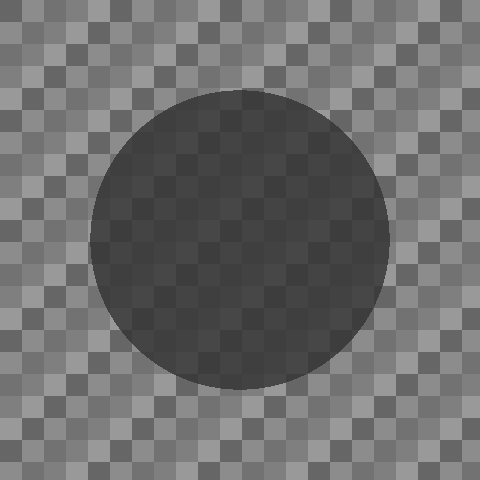

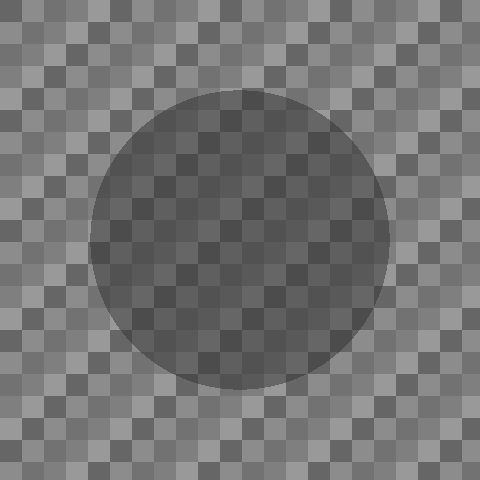

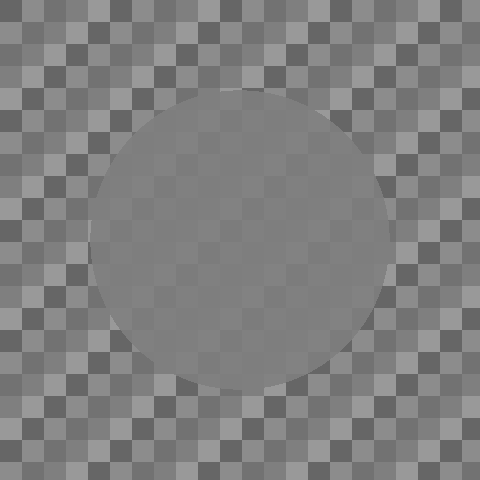

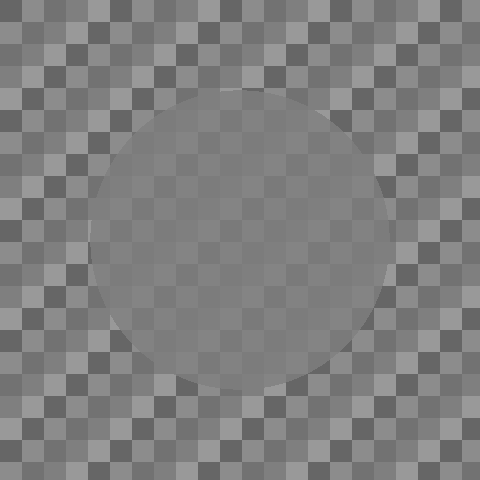

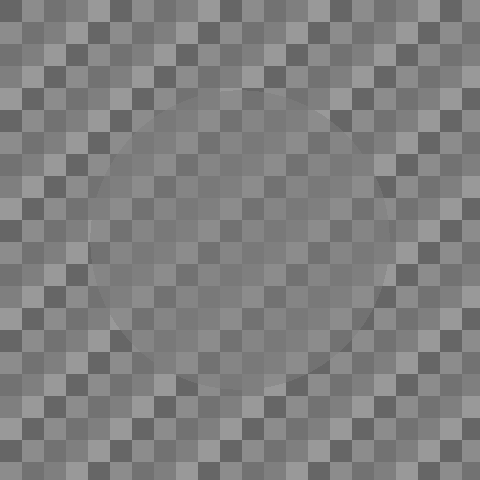

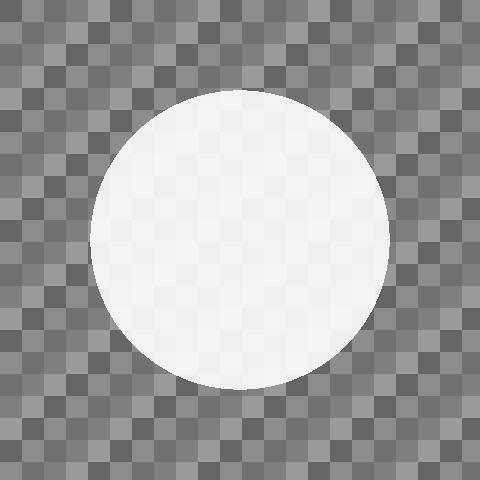

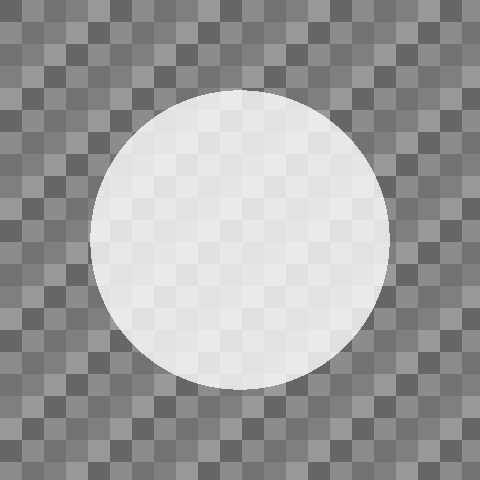

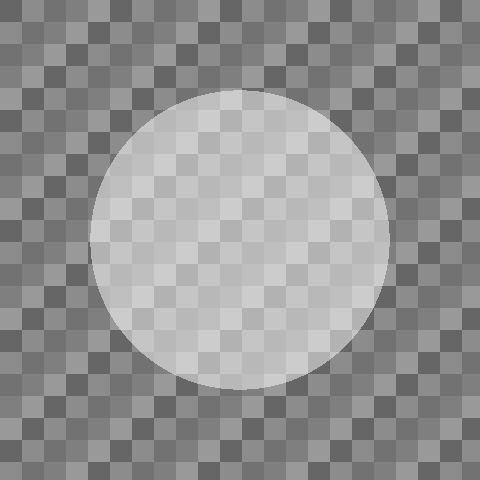

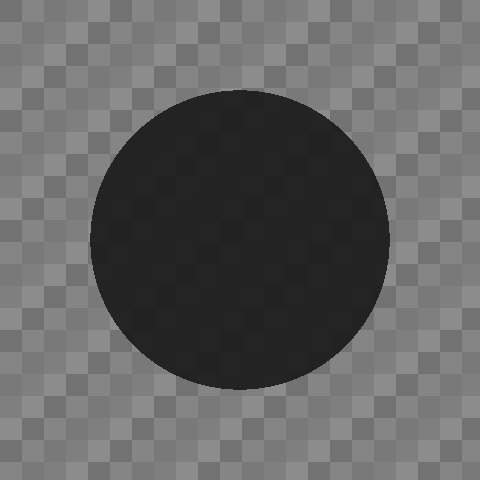

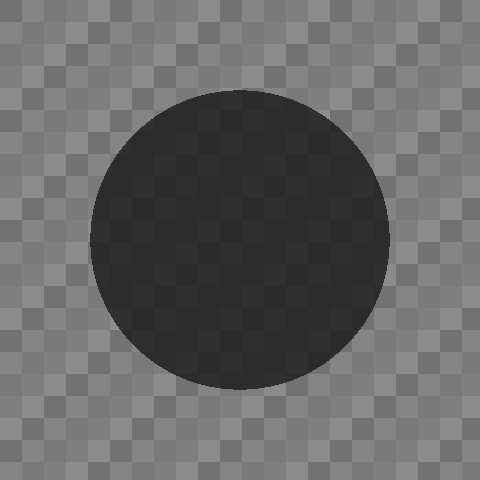

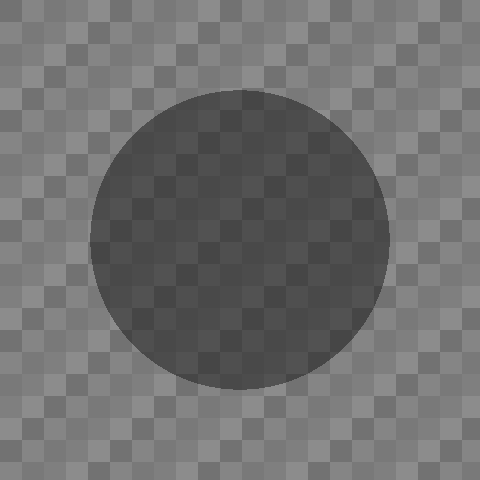

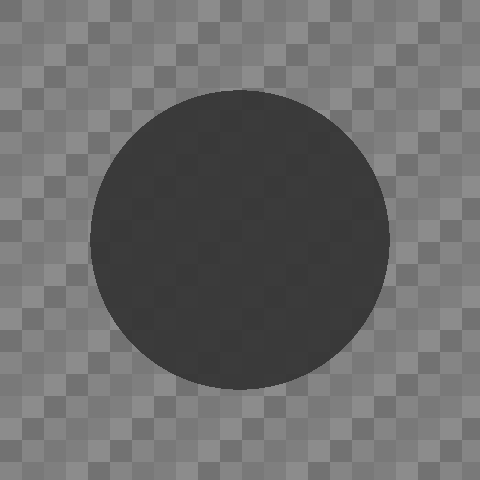

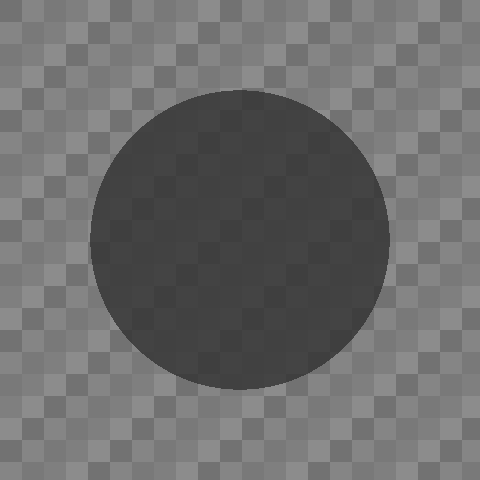

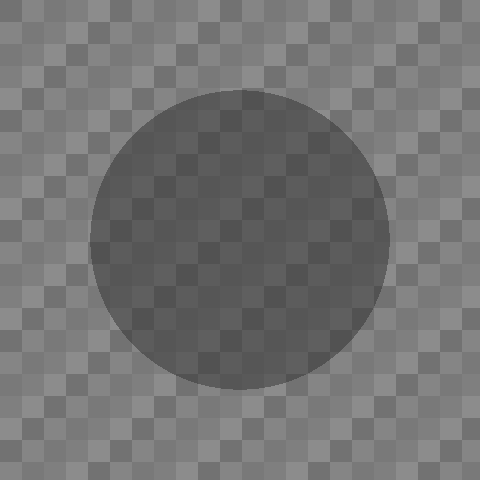

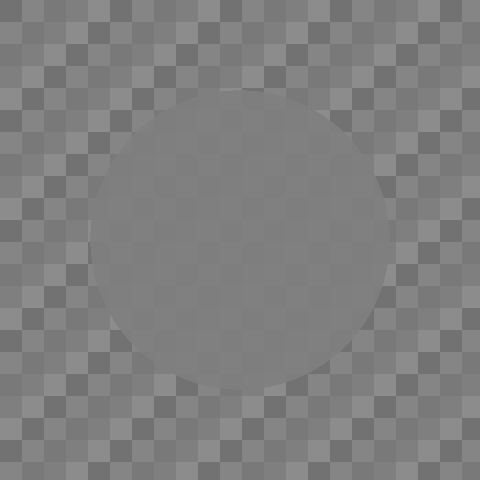

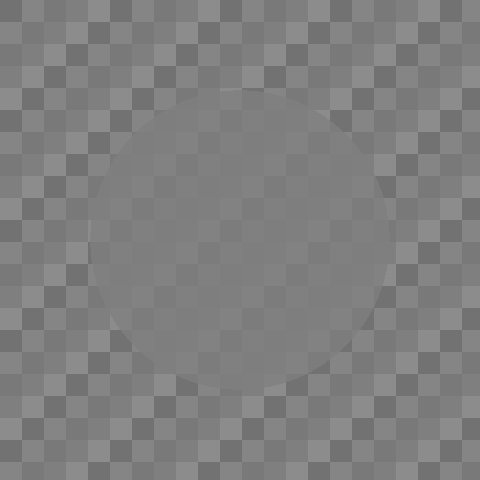

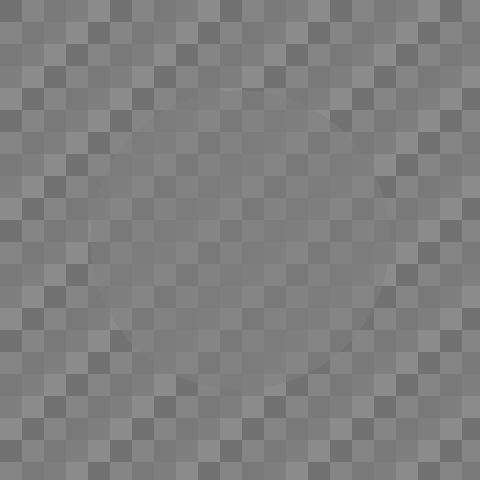

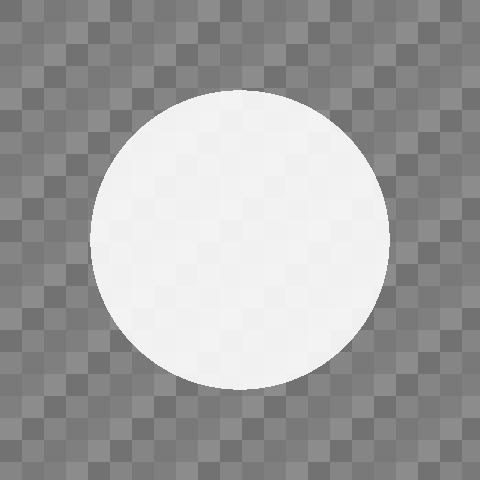

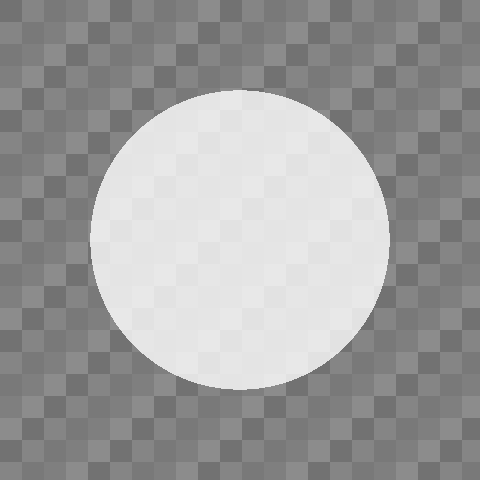

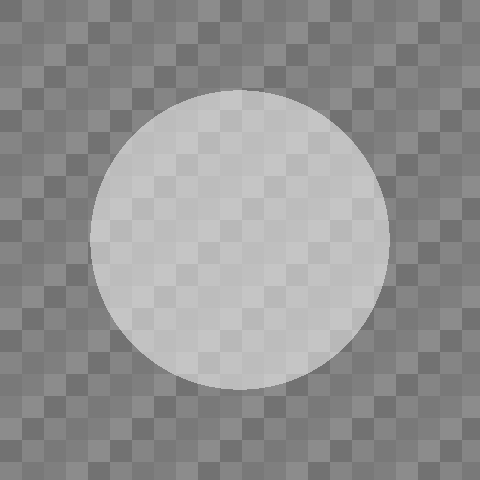

In [5]:
im_arrays = []
for i in range(0,len(images)): 
    im = to_array(i)
    im_arrays.append(im)  

In [6]:
# The transparent media with alpha and tau values on the background with highest contrast
# is cut out and pasted on variegated checkerboards with different background contrasts.

stimuli = []
for i in range(0, 12):
    tm = images[i] # image which transparent medium is taken from (stimuli with highest bg contrast)
    stimuli.append(np.array(tm))
    
    for j in range(i+12, len(images), 12):
        
        bg = images[j] # image to put it

        back_im = bg.copy() 
        back_im.paste(tm, (0, 0), mask_im) # replaced 
        im = np.array(back_im)
        
        stimuli.append(im)
        display(im)
    
  
    

array([[ 12,  12,  12, ..., 184, 184, 184],
       [ 12,  12,  12, ..., 184, 184, 184],
       [ 12,  12,  12, ..., 184, 184, 184],
       ...,
       [184, 184, 184, ...,  70,  70,  70],
       [184, 184, 184, ...,  70,  70,  70],
       [184, 184, 184, ...,  70,  70,  70]], dtype=uint8)

array([[ 25,  25,  25, ..., 178, 178, 178],
       [ 25,  25,  25, ..., 178, 178, 178],
       [ 25,  25,  25, ..., 178, 178, 178],
       ...,
       [178, 178, 178, ...,  76,  76,  76],
       [178, 178, 178, ...,  76,  76,  76],
       [178, 178, 178, ...,  76,  76,  76]], dtype=uint8)

array([[ 38,  38,  38, ..., 172, 172, 172],
       [ 38,  38,  38, ..., 172, 172, 172],
       [ 38,  38,  38, ..., 172, 172, 172],
       ...,
       [172, 172, 172, ...,  82,  82,  82],
       [172, 172, 172, ...,  82,  82,  82],
       [172, 172, 172, ...,  82,  82,  82]], dtype=uint8)

array([[ 51,  51,  51, ..., 165, 165, 165],
       [ 51,  51,  51, ..., 165, 165, 165],
       [ 51,  51,  51, ..., 165, 165, 165],
       ...,
       [165, 165, 165, ...,  89,  89,  89],
       [165, 165, 165, ...,  89,  89,  89],
       [165, 165, 165, ...,  89,  89,  89]], dtype=uint8)

array([[ 63,  63,  63, ..., 159, 159, 159],
       [ 63,  63,  63, ..., 159, 159, 159],
       [ 63,  63,  63, ..., 159, 159, 159],
       ...,
       [159, 159, 159, ...,  95,  95,  95],
       [159, 159, 159, ...,  95,  95,  95],
       [159, 159, 159, ...,  95,  95,  95]], dtype=uint8)

array([[ 76,  76,  76, ..., 153, 153, 153],
       [ 76,  76,  76, ..., 153, 153, 153],
       [ 76,  76,  76, ..., 153, 153, 153],
       ...,
       [153, 153, 153, ..., 102, 102, 102],
       [153, 153, 153, ..., 102, 102, 102],
       [153, 153, 153, ..., 102, 102, 102]], dtype=uint8)

array([[ 89,  89,  89, ..., 146, 146, 146],
       [ 89,  89,  89, ..., 146, 146, 146],
       [ 89,  89,  89, ..., 146, 146, 146],
       ...,
       [146, 146, 146, ..., 108, 108, 108],
       [146, 146, 146, ..., 108, 108, 108],
       [146, 146, 146, ..., 108, 108, 108]], dtype=uint8)

array([[102, 102, 102, ..., 140, 140, 140],
       [102, 102, 102, ..., 140, 140, 140],
       [102, 102, 102, ..., 140, 140, 140],
       ...,
       [140, 140, 140, ..., 114, 114, 114],
       [140, 140, 140, ..., 114, 114, 114],
       [140, 140, 140, ..., 114, 114, 114]], dtype=uint8)

array([[114, 114, 114, ..., 133, 133, 133],
       [114, 114, 114, ..., 133, 133, 133],
       [114, 114, 114, ..., 133, 133, 133],
       ...,
       [133, 133, 133, ..., 121, 121, 121],
       [133, 133, 133, ..., 121, 121, 121],
       [133, 133, 133, ..., 121, 121, 121]], dtype=uint8)

array([[ 12,  12,  12, ..., 184, 184, 184],
       [ 12,  12,  12, ..., 184, 184, 184],
       [ 12,  12,  12, ..., 184, 184, 184],
       ...,
       [184, 184, 184, ...,  70,  70,  70],
       [184, 184, 184, ...,  70,  70,  70],
       [184, 184, 184, ...,  70,  70,  70]], dtype=uint8)

array([[ 25,  25,  25, ..., 178, 178, 178],
       [ 25,  25,  25, ..., 178, 178, 178],
       [ 25,  25,  25, ..., 178, 178, 178],
       ...,
       [178, 178, 178, ...,  76,  76,  76],
       [178, 178, 178, ...,  76,  76,  76],
       [178, 178, 178, ...,  76,  76,  76]], dtype=uint8)

array([[ 38,  38,  38, ..., 172, 172, 172],
       [ 38,  38,  38, ..., 172, 172, 172],
       [ 38,  38,  38, ..., 172, 172, 172],
       ...,
       [172, 172, 172, ...,  82,  82,  82],
       [172, 172, 172, ...,  82,  82,  82],
       [172, 172, 172, ...,  82,  82,  82]], dtype=uint8)

array([[ 51,  51,  51, ..., 165, 165, 165],
       [ 51,  51,  51, ..., 165, 165, 165],
       [ 51,  51,  51, ..., 165, 165, 165],
       ...,
       [165, 165, 165, ...,  89,  89,  89],
       [165, 165, 165, ...,  89,  89,  89],
       [165, 165, 165, ...,  89,  89,  89]], dtype=uint8)

array([[ 63,  63,  63, ..., 159, 159, 159],
       [ 63,  63,  63, ..., 159, 159, 159],
       [ 63,  63,  63, ..., 159, 159, 159],
       ...,
       [159, 159, 159, ...,  95,  95,  95],
       [159, 159, 159, ...,  95,  95,  95],
       [159, 159, 159, ...,  95,  95,  95]], dtype=uint8)

array([[ 76,  76,  76, ..., 153, 153, 153],
       [ 76,  76,  76, ..., 153, 153, 153],
       [ 76,  76,  76, ..., 153, 153, 153],
       ...,
       [153, 153, 153, ..., 102, 102, 102],
       [153, 153, 153, ..., 102, 102, 102],
       [153, 153, 153, ..., 102, 102, 102]], dtype=uint8)

array([[ 89,  89,  89, ..., 146, 146, 146],
       [ 89,  89,  89, ..., 146, 146, 146],
       [ 89,  89,  89, ..., 146, 146, 146],
       ...,
       [146, 146, 146, ..., 108, 108, 108],
       [146, 146, 146, ..., 108, 108, 108],
       [146, 146, 146, ..., 108, 108, 108]], dtype=uint8)

array([[102, 102, 102, ..., 140, 140, 140],
       [102, 102, 102, ..., 140, 140, 140],
       [102, 102, 102, ..., 140, 140, 140],
       ...,
       [140, 140, 140, ..., 114, 114, 114],
       [140, 140, 140, ..., 114, 114, 114],
       [140, 140, 140, ..., 114, 114, 114]], dtype=uint8)

array([[114, 114, 114, ..., 133, 133, 133],
       [114, 114, 114, ..., 133, 133, 133],
       [114, 114, 114, ..., 133, 133, 133],
       ...,
       [133, 133, 133, ..., 121, 121, 121],
       [133, 133, 133, ..., 121, 121, 121],
       [133, 133, 133, ..., 121, 121, 121]], dtype=uint8)

array([[ 12,  12,  12, ..., 184, 184, 184],
       [ 12,  12,  12, ..., 184, 184, 184],
       [ 12,  12,  12, ..., 184, 184, 184],
       ...,
       [184, 184, 184, ...,  70,  70,  70],
       [184, 184, 184, ...,  70,  70,  70],
       [184, 184, 184, ...,  70,  70,  70]], dtype=uint8)

array([[ 25,  25,  25, ..., 178, 178, 178],
       [ 25,  25,  25, ..., 178, 178, 178],
       [ 25,  25,  25, ..., 178, 178, 178],
       ...,
       [178, 178, 178, ...,  76,  76,  76],
       [178, 178, 178, ...,  76,  76,  76],
       [178, 178, 178, ...,  76,  76,  76]], dtype=uint8)

array([[ 38,  38,  38, ..., 172, 172, 172],
       [ 38,  38,  38, ..., 172, 172, 172],
       [ 38,  38,  38, ..., 172, 172, 172],
       ...,
       [172, 172, 172, ...,  82,  82,  82],
       [172, 172, 172, ...,  82,  82,  82],
       [172, 172, 172, ...,  82,  82,  82]], dtype=uint8)

array([[ 51,  51,  51, ..., 165, 165, 165],
       [ 51,  51,  51, ..., 165, 165, 165],
       [ 51,  51,  51, ..., 165, 165, 165],
       ...,
       [165, 165, 165, ...,  89,  89,  89],
       [165, 165, 165, ...,  89,  89,  89],
       [165, 165, 165, ...,  89,  89,  89]], dtype=uint8)

array([[ 63,  63,  63, ..., 159, 159, 159],
       [ 63,  63,  63, ..., 159, 159, 159],
       [ 63,  63,  63, ..., 159, 159, 159],
       ...,
       [159, 159, 159, ...,  95,  95,  95],
       [159, 159, 159, ...,  95,  95,  95],
       [159, 159, 159, ...,  95,  95,  95]], dtype=uint8)

array([[ 76,  76,  76, ..., 153, 153, 153],
       [ 76,  76,  76, ..., 153, 153, 153],
       [ 76,  76,  76, ..., 153, 153, 153],
       ...,
       [153, 153, 153, ..., 102, 102, 102],
       [153, 153, 153, ..., 102, 102, 102],
       [153, 153, 153, ..., 102, 102, 102]], dtype=uint8)

array([[ 89,  89,  89, ..., 146, 146, 146],
       [ 89,  89,  89, ..., 146, 146, 146],
       [ 89,  89,  89, ..., 146, 146, 146],
       ...,
       [146, 146, 146, ..., 108, 108, 108],
       [146, 146, 146, ..., 108, 108, 108],
       [146, 146, 146, ..., 108, 108, 108]], dtype=uint8)

array([[102, 102, 102, ..., 140, 140, 140],
       [102, 102, 102, ..., 140, 140, 140],
       [102, 102, 102, ..., 140, 140, 140],
       ...,
       [140, 140, 140, ..., 114, 114, 114],
       [140, 140, 140, ..., 114, 114, 114],
       [140, 140, 140, ..., 114, 114, 114]], dtype=uint8)

array([[114, 114, 114, ..., 133, 133, 133],
       [114, 114, 114, ..., 133, 133, 133],
       [114, 114, 114, ..., 133, 133, 133],
       ...,
       [133, 133, 133, ..., 121, 121, 121],
       [133, 133, 133, ..., 121, 121, 121],
       [133, 133, 133, ..., 121, 121, 121]], dtype=uint8)

array([[ 12,  12,  12, ..., 184, 184, 184],
       [ 12,  12,  12, ..., 184, 184, 184],
       [ 12,  12,  12, ..., 184, 184, 184],
       ...,
       [184, 184, 184, ...,  70,  70,  70],
       [184, 184, 184, ...,  70,  70,  70],
       [184, 184, 184, ...,  70,  70,  70]], dtype=uint8)

array([[ 25,  25,  25, ..., 178, 178, 178],
       [ 25,  25,  25, ..., 178, 178, 178],
       [ 25,  25,  25, ..., 178, 178, 178],
       ...,
       [178, 178, 178, ...,  76,  76,  76],
       [178, 178, 178, ...,  76,  76,  76],
       [178, 178, 178, ...,  76,  76,  76]], dtype=uint8)

array([[ 38,  38,  38, ..., 172, 172, 172],
       [ 38,  38,  38, ..., 172, 172, 172],
       [ 38,  38,  38, ..., 172, 172, 172],
       ...,
       [172, 172, 172, ...,  82,  82,  82],
       [172, 172, 172, ...,  82,  82,  82],
       [172, 172, 172, ...,  82,  82,  82]], dtype=uint8)

array([[ 51,  51,  51, ..., 165, 165, 165],
       [ 51,  51,  51, ..., 165, 165, 165],
       [ 51,  51,  51, ..., 165, 165, 165],
       ...,
       [165, 165, 165, ...,  89,  89,  89],
       [165, 165, 165, ...,  89,  89,  89],
       [165, 165, 165, ...,  89,  89,  89]], dtype=uint8)

array([[ 63,  63,  63, ..., 159, 159, 159],
       [ 63,  63,  63, ..., 159, 159, 159],
       [ 63,  63,  63, ..., 159, 159, 159],
       ...,
       [159, 159, 159, ...,  95,  95,  95],
       [159, 159, 159, ...,  95,  95,  95],
       [159, 159, 159, ...,  95,  95,  95]], dtype=uint8)

array([[ 76,  76,  76, ..., 153, 153, 153],
       [ 76,  76,  76, ..., 153, 153, 153],
       [ 76,  76,  76, ..., 153, 153, 153],
       ...,
       [153, 153, 153, ..., 102, 102, 102],
       [153, 153, 153, ..., 102, 102, 102],
       [153, 153, 153, ..., 102, 102, 102]], dtype=uint8)

array([[ 89,  89,  89, ..., 146, 146, 146],
       [ 89,  89,  89, ..., 146, 146, 146],
       [ 89,  89,  89, ..., 146, 146, 146],
       ...,
       [146, 146, 146, ..., 108, 108, 108],
       [146, 146, 146, ..., 108, 108, 108],
       [146, 146, 146, ..., 108, 108, 108]], dtype=uint8)

array([[102, 102, 102, ..., 140, 140, 140],
       [102, 102, 102, ..., 140, 140, 140],
       [102, 102, 102, ..., 140, 140, 140],
       ...,
       [140, 140, 140, ..., 114, 114, 114],
       [140, 140, 140, ..., 114, 114, 114],
       [140, 140, 140, ..., 114, 114, 114]], dtype=uint8)

array([[114, 114, 114, ..., 133, 133, 133],
       [114, 114, 114, ..., 133, 133, 133],
       [114, 114, 114, ..., 133, 133, 133],
       ...,
       [133, 133, 133, ..., 121, 121, 121],
       [133, 133, 133, ..., 121, 121, 121],
       [133, 133, 133, ..., 121, 121, 121]], dtype=uint8)

array([[ 12,  12,  12, ..., 184, 184, 184],
       [ 12,  12,  12, ..., 184, 184, 184],
       [ 12,  12,  12, ..., 184, 184, 184],
       ...,
       [184, 184, 184, ...,  70,  70,  70],
       [184, 184, 184, ...,  70,  70,  70],
       [184, 184, 184, ...,  70,  70,  70]], dtype=uint8)

array([[ 25,  25,  25, ..., 178, 178, 178],
       [ 25,  25,  25, ..., 178, 178, 178],
       [ 25,  25,  25, ..., 178, 178, 178],
       ...,
       [178, 178, 178, ...,  76,  76,  76],
       [178, 178, 178, ...,  76,  76,  76],
       [178, 178, 178, ...,  76,  76,  76]], dtype=uint8)

array([[ 38,  38,  38, ..., 172, 172, 172],
       [ 38,  38,  38, ..., 172, 172, 172],
       [ 38,  38,  38, ..., 172, 172, 172],
       ...,
       [172, 172, 172, ...,  82,  82,  82],
       [172, 172, 172, ...,  82,  82,  82],
       [172, 172, 172, ...,  82,  82,  82]], dtype=uint8)

array([[ 51,  51,  51, ..., 165, 165, 165],
       [ 51,  51,  51, ..., 165, 165, 165],
       [ 51,  51,  51, ..., 165, 165, 165],
       ...,
       [165, 165, 165, ...,  89,  89,  89],
       [165, 165, 165, ...,  89,  89,  89],
       [165, 165, 165, ...,  89,  89,  89]], dtype=uint8)

array([[ 63,  63,  63, ..., 159, 159, 159],
       [ 63,  63,  63, ..., 159, 159, 159],
       [ 63,  63,  63, ..., 159, 159, 159],
       ...,
       [159, 159, 159, ...,  95,  95,  95],
       [159, 159, 159, ...,  95,  95,  95],
       [159, 159, 159, ...,  95,  95,  95]], dtype=uint8)

array([[ 76,  76,  76, ..., 153, 153, 153],
       [ 76,  76,  76, ..., 153, 153, 153],
       [ 76,  76,  76, ..., 153, 153, 153],
       ...,
       [153, 153, 153, ..., 102, 102, 102],
       [153, 153, 153, ..., 102, 102, 102],
       [153, 153, 153, ..., 102, 102, 102]], dtype=uint8)

array([[ 89,  89,  89, ..., 146, 146, 146],
       [ 89,  89,  89, ..., 146, 146, 146],
       [ 89,  89,  89, ..., 146, 146, 146],
       ...,
       [146, 146, 146, ..., 108, 108, 108],
       [146, 146, 146, ..., 108, 108, 108],
       [146, 146, 146, ..., 108, 108, 108]], dtype=uint8)

array([[102, 102, 102, ..., 140, 140, 140],
       [102, 102, 102, ..., 140, 140, 140],
       [102, 102, 102, ..., 140, 140, 140],
       ...,
       [140, 140, 140, ..., 114, 114, 114],
       [140, 140, 140, ..., 114, 114, 114],
       [140, 140, 140, ..., 114, 114, 114]], dtype=uint8)

array([[114, 114, 114, ..., 133, 133, 133],
       [114, 114, 114, ..., 133, 133, 133],
       [114, 114, 114, ..., 133, 133, 133],
       ...,
       [133, 133, 133, ..., 121, 121, 121],
       [133, 133, 133, ..., 121, 121, 121],
       [133, 133, 133, ..., 121, 121, 121]], dtype=uint8)

array([[ 12,  12,  12, ..., 184, 184, 184],
       [ 12,  12,  12, ..., 184, 184, 184],
       [ 12,  12,  12, ..., 184, 184, 184],
       ...,
       [184, 184, 184, ...,  70,  70,  70],
       [184, 184, 184, ...,  70,  70,  70],
       [184, 184, 184, ...,  70,  70,  70]], dtype=uint8)

array([[ 25,  25,  25, ..., 178, 178, 178],
       [ 25,  25,  25, ..., 178, 178, 178],
       [ 25,  25,  25, ..., 178, 178, 178],
       ...,
       [178, 178, 178, ...,  76,  76,  76],
       [178, 178, 178, ...,  76,  76,  76],
       [178, 178, 178, ...,  76,  76,  76]], dtype=uint8)

array([[ 38,  38,  38, ..., 172, 172, 172],
       [ 38,  38,  38, ..., 172, 172, 172],
       [ 38,  38,  38, ..., 172, 172, 172],
       ...,
       [172, 172, 172, ...,  82,  82,  82],
       [172, 172, 172, ...,  82,  82,  82],
       [172, 172, 172, ...,  82,  82,  82]], dtype=uint8)

array([[ 51,  51,  51, ..., 165, 165, 165],
       [ 51,  51,  51, ..., 165, 165, 165],
       [ 51,  51,  51, ..., 165, 165, 165],
       ...,
       [165, 165, 165, ...,  89,  89,  89],
       [165, 165, 165, ...,  89,  89,  89],
       [165, 165, 165, ...,  89,  89,  89]], dtype=uint8)

array([[ 63,  63,  63, ..., 159, 159, 159],
       [ 63,  63,  63, ..., 159, 159, 159],
       [ 63,  63,  63, ..., 159, 159, 159],
       ...,
       [159, 159, 159, ...,  95,  95,  95],
       [159, 159, 159, ...,  95,  95,  95],
       [159, 159, 159, ...,  95,  95,  95]], dtype=uint8)

array([[ 76,  76,  76, ..., 153, 153, 153],
       [ 76,  76,  76, ..., 153, 153, 153],
       [ 76,  76,  76, ..., 153, 153, 153],
       ...,
       [153, 153, 153, ..., 102, 102, 102],
       [153, 153, 153, ..., 102, 102, 102],
       [153, 153, 153, ..., 102, 102, 102]], dtype=uint8)

array([[ 89,  89,  89, ..., 146, 146, 146],
       [ 89,  89,  89, ..., 146, 146, 146],
       [ 89,  89,  89, ..., 146, 146, 146],
       ...,
       [146, 146, 146, ..., 108, 108, 108],
       [146, 146, 146, ..., 108, 108, 108],
       [146, 146, 146, ..., 108, 108, 108]], dtype=uint8)

array([[102, 102, 102, ..., 140, 140, 140],
       [102, 102, 102, ..., 140, 140, 140],
       [102, 102, 102, ..., 140, 140, 140],
       ...,
       [140, 140, 140, ..., 114, 114, 114],
       [140, 140, 140, ..., 114, 114, 114],
       [140, 140, 140, ..., 114, 114, 114]], dtype=uint8)

array([[114, 114, 114, ..., 133, 133, 133],
       [114, 114, 114, ..., 133, 133, 133],
       [114, 114, 114, ..., 133, 133, 133],
       ...,
       [133, 133, 133, ..., 121, 121, 121],
       [133, 133, 133, ..., 121, 121, 121],
       [133, 133, 133, ..., 121, 121, 121]], dtype=uint8)

array([[ 12,  12,  12, ..., 184, 184, 184],
       [ 12,  12,  12, ..., 184, 184, 184],
       [ 12,  12,  12, ..., 184, 184, 184],
       ...,
       [184, 184, 184, ...,  70,  70,  70],
       [184, 184, 184, ...,  70,  70,  70],
       [184, 184, 184, ...,  70,  70,  70]], dtype=uint8)

array([[ 25,  25,  25, ..., 178, 178, 178],
       [ 25,  25,  25, ..., 178, 178, 178],
       [ 25,  25,  25, ..., 178, 178, 178],
       ...,
       [178, 178, 178, ...,  76,  76,  76],
       [178, 178, 178, ...,  76,  76,  76],
       [178, 178, 178, ...,  76,  76,  76]], dtype=uint8)

array([[ 38,  38,  38, ..., 172, 172, 172],
       [ 38,  38,  38, ..., 172, 172, 172],
       [ 38,  38,  38, ..., 172, 172, 172],
       ...,
       [172, 172, 172, ...,  82,  82,  82],
       [172, 172, 172, ...,  82,  82,  82],
       [172, 172, 172, ...,  82,  82,  82]], dtype=uint8)

array([[ 51,  51,  51, ..., 165, 165, 165],
       [ 51,  51,  51, ..., 165, 165, 165],
       [ 51,  51,  51, ..., 165, 165, 165],
       ...,
       [165, 165, 165, ...,  89,  89,  89],
       [165, 165, 165, ...,  89,  89,  89],
       [165, 165, 165, ...,  89,  89,  89]], dtype=uint8)

array([[ 63,  63,  63, ..., 159, 159, 159],
       [ 63,  63,  63, ..., 159, 159, 159],
       [ 63,  63,  63, ..., 159, 159, 159],
       ...,
       [159, 159, 159, ...,  95,  95,  95],
       [159, 159, 159, ...,  95,  95,  95],
       [159, 159, 159, ...,  95,  95,  95]], dtype=uint8)

array([[ 76,  76,  76, ..., 153, 153, 153],
       [ 76,  76,  76, ..., 153, 153, 153],
       [ 76,  76,  76, ..., 153, 153, 153],
       ...,
       [153, 153, 153, ..., 102, 102, 102],
       [153, 153, 153, ..., 102, 102, 102],
       [153, 153, 153, ..., 102, 102, 102]], dtype=uint8)

array([[ 89,  89,  89, ..., 146, 146, 146],
       [ 89,  89,  89, ..., 146, 146, 146],
       [ 89,  89,  89, ..., 146, 146, 146],
       ...,
       [146, 146, 146, ..., 108, 108, 108],
       [146, 146, 146, ..., 108, 108, 108],
       [146, 146, 146, ..., 108, 108, 108]], dtype=uint8)

array([[102, 102, 102, ..., 140, 140, 140],
       [102, 102, 102, ..., 140, 140, 140],
       [102, 102, 102, ..., 140, 140, 140],
       ...,
       [140, 140, 140, ..., 114, 114, 114],
       [140, 140, 140, ..., 114, 114, 114],
       [140, 140, 140, ..., 114, 114, 114]], dtype=uint8)

array([[114, 114, 114, ..., 133, 133, 133],
       [114, 114, 114, ..., 133, 133, 133],
       [114, 114, 114, ..., 133, 133, 133],
       ...,
       [133, 133, 133, ..., 121, 121, 121],
       [133, 133, 133, ..., 121, 121, 121],
       [133, 133, 133, ..., 121, 121, 121]], dtype=uint8)

array([[ 12,  12,  12, ..., 184, 184, 184],
       [ 12,  12,  12, ..., 184, 184, 184],
       [ 12,  12,  12, ..., 184, 184, 184],
       ...,
       [184, 184, 184, ...,  70,  70,  70],
       [184, 184, 184, ...,  70,  70,  70],
       [184, 184, 184, ...,  70,  70,  70]], dtype=uint8)

array([[ 25,  25,  25, ..., 178, 178, 178],
       [ 25,  25,  25, ..., 178, 178, 178],
       [ 25,  25,  25, ..., 178, 178, 178],
       ...,
       [178, 178, 178, ...,  76,  76,  76],
       [178, 178, 178, ...,  76,  76,  76],
       [178, 178, 178, ...,  76,  76,  76]], dtype=uint8)

array([[ 38,  38,  38, ..., 172, 172, 172],
       [ 38,  38,  38, ..., 172, 172, 172],
       [ 38,  38,  38, ..., 172, 172, 172],
       ...,
       [172, 172, 172, ...,  82,  82,  82],
       [172, 172, 172, ...,  82,  82,  82],
       [172, 172, 172, ...,  82,  82,  82]], dtype=uint8)

array([[ 51,  51,  51, ..., 165, 165, 165],
       [ 51,  51,  51, ..., 165, 165, 165],
       [ 51,  51,  51, ..., 165, 165, 165],
       ...,
       [165, 165, 165, ...,  89,  89,  89],
       [165, 165, 165, ...,  89,  89,  89],
       [165, 165, 165, ...,  89,  89,  89]], dtype=uint8)

array([[ 63,  63,  63, ..., 159, 159, 159],
       [ 63,  63,  63, ..., 159, 159, 159],
       [ 63,  63,  63, ..., 159, 159, 159],
       ...,
       [159, 159, 159, ...,  95,  95,  95],
       [159, 159, 159, ...,  95,  95,  95],
       [159, 159, 159, ...,  95,  95,  95]], dtype=uint8)

array([[ 76,  76,  76, ..., 153, 153, 153],
       [ 76,  76,  76, ..., 153, 153, 153],
       [ 76,  76,  76, ..., 153, 153, 153],
       ...,
       [153, 153, 153, ..., 102, 102, 102],
       [153, 153, 153, ..., 102, 102, 102],
       [153, 153, 153, ..., 102, 102, 102]], dtype=uint8)

array([[ 89,  89,  89, ..., 146, 146, 146],
       [ 89,  89,  89, ..., 146, 146, 146],
       [ 89,  89,  89, ..., 146, 146, 146],
       ...,
       [146, 146, 146, ..., 108, 108, 108],
       [146, 146, 146, ..., 108, 108, 108],
       [146, 146, 146, ..., 108, 108, 108]], dtype=uint8)

array([[102, 102, 102, ..., 140, 140, 140],
       [102, 102, 102, ..., 140, 140, 140],
       [102, 102, 102, ..., 140, 140, 140],
       ...,
       [140, 140, 140, ..., 114, 114, 114],
       [140, 140, 140, ..., 114, 114, 114],
       [140, 140, 140, ..., 114, 114, 114]], dtype=uint8)

array([[114, 114, 114, ..., 133, 133, 133],
       [114, 114, 114, ..., 133, 133, 133],
       [114, 114, 114, ..., 133, 133, 133],
       ...,
       [133, 133, 133, ..., 121, 121, 121],
       [133, 133, 133, ..., 121, 121, 121],
       [133, 133, 133, ..., 121, 121, 121]], dtype=uint8)

array([[ 12,  12,  12, ..., 184, 184, 184],
       [ 12,  12,  12, ..., 184, 184, 184],
       [ 12,  12,  12, ..., 184, 184, 184],
       ...,
       [184, 184, 184, ...,  70,  70,  70],
       [184, 184, 184, ...,  70,  70,  70],
       [184, 184, 184, ...,  70,  70,  70]], dtype=uint8)

array([[ 25,  25,  25, ..., 178, 178, 178],
       [ 25,  25,  25, ..., 178, 178, 178],
       [ 25,  25,  25, ..., 178, 178, 178],
       ...,
       [178, 178, 178, ...,  76,  76,  76],
       [178, 178, 178, ...,  76,  76,  76],
       [178, 178, 178, ...,  76,  76,  76]], dtype=uint8)

array([[ 38,  38,  38, ..., 172, 172, 172],
       [ 38,  38,  38, ..., 172, 172, 172],
       [ 38,  38,  38, ..., 172, 172, 172],
       ...,
       [172, 172, 172, ...,  82,  82,  82],
       [172, 172, 172, ...,  82,  82,  82],
       [172, 172, 172, ...,  82,  82,  82]], dtype=uint8)

array([[ 51,  51,  51, ..., 165, 165, 165],
       [ 51,  51,  51, ..., 165, 165, 165],
       [ 51,  51,  51, ..., 165, 165, 165],
       ...,
       [165, 165, 165, ...,  89,  89,  89],
       [165, 165, 165, ...,  89,  89,  89],
       [165, 165, 165, ...,  89,  89,  89]], dtype=uint8)

array([[ 63,  63,  63, ..., 159, 159, 159],
       [ 63,  63,  63, ..., 159, 159, 159],
       [ 63,  63,  63, ..., 159, 159, 159],
       ...,
       [159, 159, 159, ...,  95,  95,  95],
       [159, 159, 159, ...,  95,  95,  95],
       [159, 159, 159, ...,  95,  95,  95]], dtype=uint8)

array([[ 76,  76,  76, ..., 153, 153, 153],
       [ 76,  76,  76, ..., 153, 153, 153],
       [ 76,  76,  76, ..., 153, 153, 153],
       ...,
       [153, 153, 153, ..., 102, 102, 102],
       [153, 153, 153, ..., 102, 102, 102],
       [153, 153, 153, ..., 102, 102, 102]], dtype=uint8)

array([[ 89,  89,  89, ..., 146, 146, 146],
       [ 89,  89,  89, ..., 146, 146, 146],
       [ 89,  89,  89, ..., 146, 146, 146],
       ...,
       [146, 146, 146, ..., 108, 108, 108],
       [146, 146, 146, ..., 108, 108, 108],
       [146, 146, 146, ..., 108, 108, 108]], dtype=uint8)

array([[102, 102, 102, ..., 140, 140, 140],
       [102, 102, 102, ..., 140, 140, 140],
       [102, 102, 102, ..., 140, 140, 140],
       ...,
       [140, 140, 140, ..., 114, 114, 114],
       [140, 140, 140, ..., 114, 114, 114],
       [140, 140, 140, ..., 114, 114, 114]], dtype=uint8)

array([[114, 114, 114, ..., 133, 133, 133],
       [114, 114, 114, ..., 133, 133, 133],
       [114, 114, 114, ..., 133, 133, 133],
       ...,
       [133, 133, 133, ..., 121, 121, 121],
       [133, 133, 133, ..., 121, 121, 121],
       [133, 133, 133, ..., 121, 121, 121]], dtype=uint8)

array([[ 12,  12,  12, ..., 184, 184, 184],
       [ 12,  12,  12, ..., 184, 184, 184],
       [ 12,  12,  12, ..., 184, 184, 184],
       ...,
       [184, 184, 184, ...,  70,  70,  70],
       [184, 184, 184, ...,  70,  70,  70],
       [184, 184, 184, ...,  70,  70,  70]], dtype=uint8)

array([[ 25,  25,  25, ..., 178, 178, 178],
       [ 25,  25,  25, ..., 178, 178, 178],
       [ 25,  25,  25, ..., 178, 178, 178],
       ...,
       [178, 178, 178, ...,  76,  76,  76],
       [178, 178, 178, ...,  76,  76,  76],
       [178, 178, 178, ...,  76,  76,  76]], dtype=uint8)

array([[ 38,  38,  38, ..., 172, 172, 172],
       [ 38,  38,  38, ..., 172, 172, 172],
       [ 38,  38,  38, ..., 172, 172, 172],
       ...,
       [172, 172, 172, ...,  82,  82,  82],
       [172, 172, 172, ...,  82,  82,  82],
       [172, 172, 172, ...,  82,  82,  82]], dtype=uint8)

array([[ 51,  51,  51, ..., 165, 165, 165],
       [ 51,  51,  51, ..., 165, 165, 165],
       [ 51,  51,  51, ..., 165, 165, 165],
       ...,
       [165, 165, 165, ...,  89,  89,  89],
       [165, 165, 165, ...,  89,  89,  89],
       [165, 165, 165, ...,  89,  89,  89]], dtype=uint8)

array([[ 63,  63,  63, ..., 159, 159, 159],
       [ 63,  63,  63, ..., 159, 159, 159],
       [ 63,  63,  63, ..., 159, 159, 159],
       ...,
       [159, 159, 159, ...,  95,  95,  95],
       [159, 159, 159, ...,  95,  95,  95],
       [159, 159, 159, ...,  95,  95,  95]], dtype=uint8)

array([[ 76,  76,  76, ..., 153, 153, 153],
       [ 76,  76,  76, ..., 153, 153, 153],
       [ 76,  76,  76, ..., 153, 153, 153],
       ...,
       [153, 153, 153, ..., 102, 102, 102],
       [153, 153, 153, ..., 102, 102, 102],
       [153, 153, 153, ..., 102, 102, 102]], dtype=uint8)

array([[ 89,  89,  89, ..., 146, 146, 146],
       [ 89,  89,  89, ..., 146, 146, 146],
       [ 89,  89,  89, ..., 146, 146, 146],
       ...,
       [146, 146, 146, ..., 108, 108, 108],
       [146, 146, 146, ..., 108, 108, 108],
       [146, 146, 146, ..., 108, 108, 108]], dtype=uint8)

array([[102, 102, 102, ..., 140, 140, 140],
       [102, 102, 102, ..., 140, 140, 140],
       [102, 102, 102, ..., 140, 140, 140],
       ...,
       [140, 140, 140, ..., 114, 114, 114],
       [140, 140, 140, ..., 114, 114, 114],
       [140, 140, 140, ..., 114, 114, 114]], dtype=uint8)

array([[114, 114, 114, ..., 133, 133, 133],
       [114, 114, 114, ..., 133, 133, 133],
       [114, 114, 114, ..., 133, 133, 133],
       ...,
       [133, 133, 133, ..., 121, 121, 121],
       [133, 133, 133, ..., 121, 121, 121],
       [133, 133, 133, ..., 121, 121, 121]], dtype=uint8)

array([[ 12,  12,  12, ..., 184, 184, 184],
       [ 12,  12,  12, ..., 184, 184, 184],
       [ 12,  12,  12, ..., 184, 184, 184],
       ...,
       [184, 184, 184, ...,  70,  70,  70],
       [184, 184, 184, ...,  70,  70,  70],
       [184, 184, 184, ...,  70,  70,  70]], dtype=uint8)

array([[ 25,  25,  25, ..., 178, 178, 178],
       [ 25,  25,  25, ..., 178, 178, 178],
       [ 25,  25,  25, ..., 178, 178, 178],
       ...,
       [178, 178, 178, ...,  76,  76,  76],
       [178, 178, 178, ...,  76,  76,  76],
       [178, 178, 178, ...,  76,  76,  76]], dtype=uint8)

array([[ 38,  38,  38, ..., 172, 172, 172],
       [ 38,  38,  38, ..., 172, 172, 172],
       [ 38,  38,  38, ..., 172, 172, 172],
       ...,
       [172, 172, 172, ...,  82,  82,  82],
       [172, 172, 172, ...,  82,  82,  82],
       [172, 172, 172, ...,  82,  82,  82]], dtype=uint8)

array([[ 51,  51,  51, ..., 165, 165, 165],
       [ 51,  51,  51, ..., 165, 165, 165],
       [ 51,  51,  51, ..., 165, 165, 165],
       ...,
       [165, 165, 165, ...,  89,  89,  89],
       [165, 165, 165, ...,  89,  89,  89],
       [165, 165, 165, ...,  89,  89,  89]], dtype=uint8)

array([[ 63,  63,  63, ..., 159, 159, 159],
       [ 63,  63,  63, ..., 159, 159, 159],
       [ 63,  63,  63, ..., 159, 159, 159],
       ...,
       [159, 159, 159, ...,  95,  95,  95],
       [159, 159, 159, ...,  95,  95,  95],
       [159, 159, 159, ...,  95,  95,  95]], dtype=uint8)

array([[ 76,  76,  76, ..., 153, 153, 153],
       [ 76,  76,  76, ..., 153, 153, 153],
       [ 76,  76,  76, ..., 153, 153, 153],
       ...,
       [153, 153, 153, ..., 102, 102, 102],
       [153, 153, 153, ..., 102, 102, 102],
       [153, 153, 153, ..., 102, 102, 102]], dtype=uint8)

array([[ 89,  89,  89, ..., 146, 146, 146],
       [ 89,  89,  89, ..., 146, 146, 146],
       [ 89,  89,  89, ..., 146, 146, 146],
       ...,
       [146, 146, 146, ..., 108, 108, 108],
       [146, 146, 146, ..., 108, 108, 108],
       [146, 146, 146, ..., 108, 108, 108]], dtype=uint8)

array([[102, 102, 102, ..., 140, 140, 140],
       [102, 102, 102, ..., 140, 140, 140],
       [102, 102, 102, ..., 140, 140, 140],
       ...,
       [140, 140, 140, ..., 114, 114, 114],
       [140, 140, 140, ..., 114, 114, 114],
       [140, 140, 140, ..., 114, 114, 114]], dtype=uint8)

array([[114, 114, 114, ..., 133, 133, 133],
       [114, 114, 114, ..., 133, 133, 133],
       [114, 114, 114, ..., 133, 133, 133],
       ...,
       [133, 133, 133, ..., 121, 121, 121],
       [133, 133, 133, ..., 121, 121, 121],
       [133, 133, 133, ..., 121, 121, 121]], dtype=uint8)

array([[ 12,  12,  12, ..., 184, 184, 184],
       [ 12,  12,  12, ..., 184, 184, 184],
       [ 12,  12,  12, ..., 184, 184, 184],
       ...,
       [184, 184, 184, ...,  70,  70,  70],
       [184, 184, 184, ...,  70,  70,  70],
       [184, 184, 184, ...,  70,  70,  70]], dtype=uint8)

array([[ 25,  25,  25, ..., 178, 178, 178],
       [ 25,  25,  25, ..., 178, 178, 178],
       [ 25,  25,  25, ..., 178, 178, 178],
       ...,
       [178, 178, 178, ...,  76,  76,  76],
       [178, 178, 178, ...,  76,  76,  76],
       [178, 178, 178, ...,  76,  76,  76]], dtype=uint8)

array([[ 38,  38,  38, ..., 172, 172, 172],
       [ 38,  38,  38, ..., 172, 172, 172],
       [ 38,  38,  38, ..., 172, 172, 172],
       ...,
       [172, 172, 172, ...,  82,  82,  82],
       [172, 172, 172, ...,  82,  82,  82],
       [172, 172, 172, ...,  82,  82,  82]], dtype=uint8)

array([[ 51,  51,  51, ..., 165, 165, 165],
       [ 51,  51,  51, ..., 165, 165, 165],
       [ 51,  51,  51, ..., 165, 165, 165],
       ...,
       [165, 165, 165, ...,  89,  89,  89],
       [165, 165, 165, ...,  89,  89,  89],
       [165, 165, 165, ...,  89,  89,  89]], dtype=uint8)

array([[ 63,  63,  63, ..., 159, 159, 159],
       [ 63,  63,  63, ..., 159, 159, 159],
       [ 63,  63,  63, ..., 159, 159, 159],
       ...,
       [159, 159, 159, ...,  95,  95,  95],
       [159, 159, 159, ...,  95,  95,  95],
       [159, 159, 159, ...,  95,  95,  95]], dtype=uint8)

array([[ 76,  76,  76, ..., 153, 153, 153],
       [ 76,  76,  76, ..., 153, 153, 153],
       [ 76,  76,  76, ..., 153, 153, 153],
       ...,
       [153, 153, 153, ..., 102, 102, 102],
       [153, 153, 153, ..., 102, 102, 102],
       [153, 153, 153, ..., 102, 102, 102]], dtype=uint8)

array([[ 89,  89,  89, ..., 146, 146, 146],
       [ 89,  89,  89, ..., 146, 146, 146],
       [ 89,  89,  89, ..., 146, 146, 146],
       ...,
       [146, 146, 146, ..., 108, 108, 108],
       [146, 146, 146, ..., 108, 108, 108],
       [146, 146, 146, ..., 108, 108, 108]], dtype=uint8)

array([[102, 102, 102, ..., 140, 140, 140],
       [102, 102, 102, ..., 140, 140, 140],
       [102, 102, 102, ..., 140, 140, 140],
       ...,
       [140, 140, 140, ..., 114, 114, 114],
       [140, 140, 140, ..., 114, 114, 114],
       [140, 140, 140, ..., 114, 114, 114]], dtype=uint8)

array([[114, 114, 114, ..., 133, 133, 133],
       [114, 114, 114, ..., 133, 133, 133],
       [114, 114, 114, ..., 133, 133, 133],
       ...,
       [133, 133, 133, ..., 121, 121, 121],
       [133, 133, 133, ..., 121, 121, 121],
       [133, 133, 133, ..., 121, 121, 121]], dtype=uint8)

In [7]:
# now we apply the mask to the numpy array
def get_values_bg_and_tm(i):
    
    im = stimuli[i]
    center = im[mask==1.0]

    # center vector has only the values in the transparent region. We now
    # get the unique values in it
    
    transp_values = np.unique(center)/255
    transp_values = transp_values.round(2)
    # print('values inside transparent medium of the image',i,":", transp_values.round(2))

    # and we do the same for the surround - region without transparency
    surr = im[mask==0.0]

    surr_values = np.array(surr)
    
    surr_values = np.append(surr_values, surr_values)
    
    surr_values = np.unique(surr_values)/255
    # print('values in the background of the image',i,":", surr_values.round(2))
    return transp_values.round(2), surr_values.round(2)



In [8]:
# get values inside and outside of transparent medium for every stimuli
outside = []
inside = []
for i in range(len(stimuli)):
    a,b = get_values_bg_and_tm(i)
    inside.append(a)
    outside.append(b)

[array([0.  , 0.25, 0.5 , 0.75, 1.  ]),
 array([0.05, 0.27, 0.5 , 0.72, 0.95]),
 array([0.1, 0.3, 0.5, 0.7, 0.9]),
 array([0.15, 0.32, 0.5 , 0.67, 0.85]),
 array([0.2 , 0.35, 0.5 , 0.65, 0.8 ]),
 array([0.25, 0.37, 0.5 , 0.62, 0.75]),
 array([0.3, 0.4, 0.5, 0.6, 0.7]),
 array([0.35, 0.42, 0.5 , 0.57, 0.65]),
 array([0.4 , 0.45, 0.5 , 0.55, 0.6 ]),
 array([0.45, 0.47, 0.5 , 0.52, 0.55]),
 array([0.  , 0.25, 0.5 , 0.75, 1.  ]),
 array([0.05, 0.27, 0.5 , 0.72, 0.95]),
 array([0.1, 0.3, 0.5, 0.7, 0.9]),
 array([0.15, 0.32, 0.5 , 0.67, 0.85]),
 array([0.2 , 0.35, 0.5 , 0.65, 0.8 ]),
 array([0.25, 0.37, 0.5 , 0.62, 0.75]),
 array([0.3, 0.4, 0.5, 0.6, 0.7]),
 array([0.35, 0.42, 0.5 , 0.57, 0.65]),
 array([0.4 , 0.45, 0.5 , 0.55, 0.6 ]),
 array([0.45, 0.47, 0.5 , 0.52, 0.55]),
 array([0.  , 0.25, 0.5 , 0.75, 1.  ]),
 array([0.05, 0.27, 0.5 , 0.72, 0.95]),
 array([0.1, 0.3, 0.5, 0.7, 0.9]),
 array([0.15, 0.32, 0.5 , 0.67, 0.85]),
 array([0.2 , 0.35, 0.5 , 0.65, 0.8 ]),
 array([0.25, 0.37, 0.5 ,

In [9]:
# Calculation of the Michelson contrast

def mc(arr):
    return abs((arr.max() - arr.min())/(arr.max() + arr.min()))

contrast_bg_mc = []
MC_values_bg = [] 

# we iterate through all pairs of values out of transparency (in the background)
for k in range(len(stimuli)): 
    n = len(outside[k])
      
    # michelson contrast OUTSIDE
    
    c = abs(mc(outside[k]))
    contrast_bg_mc = c
    MC_values_bg.append(c.round(2))
    
    # print('MC in background of image ',k,":", contrast_bg_mc.round(1)) # prints the MC of each stimulus
print("Every MC of outside values: ",MC_values_bg) # a list with every MC of outside of each stimulus (144)


contrast_transp_mc = []
MC_values_transp = []

    # we now iterate through all pairs of values inside the transparency 
for k in range(len(stimuli)):    
    m = len(inside[k])
    

    # michelson contrast INSIDE

    c = abs(mc(inside[k]))
    contrast_transp_mc = c
    MC_values_transp.append(c.round(2))
    
    # print('MC inside the transparency of image ',k,":",contrast_transp_mc.round(2)) # prints the MC of each stimulus 
print("Every MC of inside values: ",MC_values_transp) # a list with every MC of inside of each stimulus (144)


Every MC of outside values:  [1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]
Every MC of inside values:  [0.36, 0.36, 0.36, 0.36, 0.36, 0.36, 0.36, 0.36, 0.36, 0.36, 0.56, 0.56, 0.56, 0.56, 0.56, 0.56, 0.56, 0.56, 0.56, 0.56, 0.83, 0.83, 0.83, 0.83, 0.83, 0.83, 0.83, 0.83, 0.83, 0.83, 0.22, 0.22, 0.22, 0.22, 0.22, 0.22, 0.22, 0.22, 0.22, 0.22, 0.38, 0.38, 0.38, 0.38, 0.38, 0.38, 0.38, 0.38, 0.38, 0.38, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71, 0.71,

In [10]:
# QUESTION: should I add mean? (line85 in original code) 
# QUESTION: if yes, where, in which line/ order?
# now we calculate the Space-averaged Michelson contrast as in the paper Aguilar & Maertens (2022)
def michelson_contrast(a, b):
    return abs(a-b)/(a+b)

contrast_bg_sam = []
SAM_values_bg = []
SAMLG_values_bg = []

# we iterate through all pairs of values out of transparency (in the background)
for k in range(len(stimuli)): 
    n = len(outside[k])       



# contrast between all possible pairs, excluding when i==j, OUTSIDE
    for i in range(n):
        for j in range(i+1, n):
            if i == j:
                continue
            c = abs(michelson_contrast(outside[k][i], outside[k][j]))
            contrast_bg_sam.append(c.round(2))
           

        
# we now calculate the log and sum
    contrast_bg = np.mean(contrast_bg_sam)
    
    samlg_bg = np.mean(np.log(contrast_bg))
    SAMLG_values_bg.append(samlg_bg.round(3))
    
    SAM_contrast_bg = np.sum(contrast_bg) / (n * n)  # QUESTION: SAM_contrast_bg = np.sum(np.mean(contrast_transp_sam))  / (n * n) ??
    SAM_values_bg.append(SAM_contrast_bg.round(3))
    
    # print('SAM in background of image ',k,":",SAM_contrast_bg.round(3))
    # print('SAMLG in background of image ',k,":",samlg_bg.round(3))
    contrast_bg_sam.clear() # cleared for the next stimuli
print(min(SAM_values_bg))
print(max(SAM_values_bg))
print(min(SAMLG_values_bg))
print(max(SAMLG_values_bg))
    
print("Every SAM of outside values: ",SAM_values_bg) # a list with every SAM of outside luminance values of each stimulus (144)
print("Every SAMLG of outside values: ",SAMLG_values_bg) # a list with every SAM of outside luminance values of each stimulus (144)


    
    
    




# we now iterate through all pairs of values in transparency 

contrast_transp_sam = []
SAM_values_transp = []
SAMLG_values_transp = []

for k in range(len(stimuli)):
    n = len(inside[k])

# contrast between all possible pairs, excluding when i==j, INSIDE
    for i in range(n):
        for j in range(i+1, n):
            if i == j:
                continue
            c = abs(michelson_contrast(inside[k][i], inside[k][j]))
            contrast_transp_sam.append(c.round(2))


# we now calculate the log and sum

    contrast = np.mean(contrast_transp_sam)
    samlg_transp = np.mean(np.log(contrast))
    SAMLG_values_transp.append(samlg_transp.round(3))
    
    SAM_contrast_transp = np.sum(contrast) / (n * n) # QUESTION: contrast = np.mean(contrast_transp_sam) right or wrong??
    SAM_values_bg.append(SAM_contrast_bg.round(3))
    SAM_values_transp.append(SAM_contrast_transp.round(3))
    
    # print('SAM in transparency of image ',k,":",SAM_contrast_transp.round(3))
    # print('SAMLG in transparency of image ',k,":",samlg_transp.round(3))
    contrast_transp_sam.clear() # cleared for the next stimuli
print(min(SAM_values_transp))
print(max(SAM_values_transp))
print(min(SAMLG_values_transp))
print(max(SAMLG_values_transp))
print("Every SAM of inside values: ",SAM_values_transp) # a list with every SAM of inside luminance values of each stimulus (144)
print("Every SAMLG of inside values: ",SAMLG_values_transp) # a list with every SAM of inside luminance values of each stimulus (144)

0.002
0.024
-2.996
-0.494
Every SAM of outside values:  [0.024, 0.021, 0.018, 0.015, 0.013, 0.01, 0.008, 0.006, 0.004, 0.002, 0.024, 0.021, 0.018, 0.015, 0.013, 0.01, 0.008, 0.006, 0.004, 0.002, 0.024, 0.021, 0.018, 0.015, 0.013, 0.01, 0.008, 0.006, 0.004, 0.002, 0.024, 0.021, 0.018, 0.015, 0.013, 0.01, 0.008, 0.006, 0.004, 0.002, 0.024, 0.021, 0.018, 0.015, 0.013, 0.01, 0.008, 0.006, 0.004, 0.002, 0.024, 0.021, 0.018, 0.015, 0.013, 0.01, 0.008, 0.006, 0.004, 0.002, 0.024, 0.021, 0.018, 0.015, 0.013, 0.01, 0.008, 0.006, 0.004, 0.002, 0.024, 0.021, 0.018, 0.015, 0.013, 0.01, 0.008, 0.006, 0.004, 0.002, 0.024, 0.021, 0.018, 0.015, 0.013, 0.01, 0.008, 0.006, 0.004, 0.002, 0.024, 0.021, 0.018, 0.015, 0.013, 0.01, 0.008, 0.006, 0.004, 0.002, 0.024, 0.021, 0.018, 0.015, 0.013, 0.01, 0.008, 0.006, 0.004, 0.002, 0.024, 0.021, 0.018, 0.015, 0.013, 0.01, 0.008, 0.006, 0.004, 0.002]
Every SAMLG of outside values:  [-0.494, -0.65, -0.807, -0.973, -1.152, -1.351, -1.59, -1.877, -2.303, -2.996, -0.4

In [11]:
# QUESTION: should I add mean? (line85 in original code) 
# now we calculate the Space-averaged Whittle contrast as in the paper Aguilar & Maertens (2022)
def michelson_contrast(a, b):
    return abs(a-b)/(a+b)

contrast_bg_saw = []
SAW_values_bg = []

# we iterate through all pairs of values out of transparency (in the background)
for k in range(len(stimuli)):
    n = len(outside[k]) 
    


# contrast between all possible pairs, excluding when i==j, OUTSIDE
    for i in range(n):
        for j in range(i+1, n):
            if i == j:
                continue
            divisor = outside[k][i] - outside[k][j]
            dividor = min(outside[k][i], outside[k][j])
            dividor = 0.01 if dividor == 0 else dividor
            x = abs(divisor/dividor)
            contrast_bg_saw.append(x.round(2))

            
# we now calculate the sum
    contrast = np.mean(contrast_bg_saw)
    SAW_contrast_bg = np.sum(contrast) / (n * n)
    SAW_values_bg.append(SAW_contrast_bg.round(3))
    # print('SAW in background of image ',k,":",SAW_contrast_bg.round(3))

    contrast_bg_saw.clear() # cleared for the next stimuli

print("Every SAW of outside values: ",SAW_values_bg) # a list with every SAW of outside luminance values of each stimulus (144)
    
    
    
    
    




# we now iterate through all pairs of values in transparency 

contrast_transp_saw = []
SAW_values_transp = []

for k in range(len(stimuli)):
    m = len(inside[k])



# contrast between all possible pairs, excluding when i==j, INSIDE
    for i in range(m):
        for j in range(i+1, m):
            if i == j:
                continue
            divisor = inside[k][i] - inside[k][j]
            dividor = min(inside[k][i], inside[k][j])
            x = abs(divisor/dividor)
            contrast_transp_saw.append(x.round(2))

# we now calculate the sum
    contrast = np.mean(contrast_transp_saw)
    SAW_contrast_transp = np.sum(contrast) / (m * m)
    SAW_values_transp.append(SAW_contrast_transp.round(3))
    # print('SAW inside transparency of image ',k,":",SAW_contrast_transp.round(3))

    contrast_transp_saw.clear() # cleared for the next stimuli

print("Every SAW of inside values: ",SAW_values_transp) # a list with every SAW of inside luminance values of each stimulus (144)

Every SAW of outside values:  [1.031, 0.206, 0.102, 0.065, 0.045, 0.032, 0.022, 0.015, 0.009, 0.004, 1.031, 0.206, 0.102, 0.065, 0.045, 0.032, 0.022, 0.015, 0.009, 0.004, 1.031, 0.206, 0.102, 0.065, 0.045, 0.032, 0.022, 0.015, 0.009, 0.004, 1.031, 0.206, 0.102, 0.065, 0.045, 0.032, 0.022, 0.015, 0.009, 0.004, 1.031, 0.206, 0.102, 0.065, 0.045, 0.032, 0.022, 0.015, 0.009, 0.004, 1.031, 0.206, 0.102, 0.065, 0.045, 0.032, 0.022, 0.015, 0.009, 0.004, 1.031, 0.206, 0.102, 0.065, 0.045, 0.032, 0.022, 0.015, 0.009, 0.004, 1.031, 0.206, 0.102, 0.065, 0.045, 0.032, 0.022, 0.015, 0.009, 0.004, 1.031, 0.206, 0.102, 0.065, 0.045, 0.032, 0.022, 0.015, 0.009, 0.004, 1.031, 0.206, 0.102, 0.065, 0.045, 0.032, 0.022, 0.015, 0.009, 0.004, 1.031, 0.206, 0.102, 0.065, 0.045, 0.032, 0.022, 0.015, 0.009, 0.004, 1.031, 0.206, 0.102, 0.065, 0.045, 0.032, 0.022, 0.015, 0.009, 0.004]
Every SAW of inside values:  [0.019, 0.019, 0.019, 0.019, 0.019, 0.019, 0.019, 0.019, 0.019, 0.019, 0.038, 0.038, 0.038, 0.038, 0

In [12]:
# we now calculate the ratio R between the contrasts inside and outside the transparent medium, R = tm_contrast / bg_contrast

r_mc_values = []
r_sam_values = []
r_samlg_values = []
r_saw_values = []


for i in range(len(stimuli)):
    

    # first, we calculate R_mc, being the Ratio between the Michelson contrasts 

    # we take calculated contrasts inside and outside the medium    
        
    mc_tm = MC_values_transp[i]
    mc_bg = MC_values_bg[i]

    # and calculate the ratio
    r_mc = abs(mc_tm/mc_bg).round(2)
    r_mc_values.append(r_mc)
    
    # print('Ratio of TM_mc / BG_mc of image ',i," = ", r_mc)


    # second, we calculate R_sam, being the Ratio between the Space-Average Michelson contrasts

    # we take calculated contrasts inside and outside the medium
    sam_tm = SAM_values_transp[i]
    sam_bg = SAM_values_bg[i]

    # and calculate the ratio
    r_sam = abs(sam_tm/sam_bg).round(2)
    r_sam_values.append(r_sam)
    # print('Ratio of TM_sam / BG_sam of image ',i," = ", r_sam)
    
   
    # third, we calculate R_samlg, being the Ratio between the Space-Average logarithm of Michelson contrasts
    
    samlg_tm = SAMLG_values_transp[i]
    samlg_bg = SAMLG_values_bg[i]

    # and calculate the ratio
    r_samlg = abs(samlg_tm/samlg_bg).round(2)
    r_samlg_values.append(r_samlg)
    # print('Ratio of TM_samlg / BG_samlg of image ',i," = ", r_samlg)


    # lastly, we calculate R_saw, being the Ratio between the Space-Average Whittle contrasts

    # we take calculated contrasts inside and outside the medium
    saw_tm = SAW_values_transp[i]
    saw_bg = SAW_values_bg[i]

    # and calculate the ratio
    r_saw = abs(saw_tm/saw_bg).round(2)
    r_saw_values.append(r_saw)
    # print('Ratio of TM_saw / BG_saw of image ',i," = ", r_saw)
    
print("Every Ratio of MC: ", r_mc_values)
print("Every Ratio of SAM: ", r_sam_values)
print("Every Ratio of SAMLG: ", r_samlg_values)
print("Every Ratio of SAW: ", r_saw_values)

Every Ratio of MC:  [0.36, 0.4, 0.45, 0.51, 0.6, 0.72, 0.9, 1.2, 1.8, 3.6, 0.56, 0.62, 0.7, 0.8, 0.93, 1.12, 1.4, 1.87, 2.8, 5.6, 0.83, 0.92, 1.04, 1.19, 1.38, 1.66, 2.07, 2.77, 4.15, 8.3, 0.22, 0.24, 0.27, 0.31, 0.37, 0.44, 0.55, 0.73, 1.1, 2.2, 0.38, 0.42, 0.48, 0.54, 0.63, 0.76, 0.95, 1.27, 1.9, 3.8, 0.71, 0.79, 0.89, 1.01, 1.18, 1.42, 1.78, 2.37, 3.55, 7.1, 0.1, 0.11, 0.12, 0.14, 0.17, 0.2, 0.25, 0.33, 0.5, 1.0, 0.2, 0.22, 0.25, 0.29, 0.33, 0.4, 0.5, 0.67, 1.0, 2.0, 0.5, 0.56, 0.62, 0.71, 0.83, 1.0, 1.25, 1.67, 2.5, 5.0, 0.05, 0.06, 0.06, 0.07, 0.08, 0.1, 0.12, 0.17, 0.25, 0.5, 0.11, 0.12, 0.14, 0.16, 0.18, 0.22, 0.27, 0.37, 0.55, 1.1, 0.33, 0.37, 0.41, 0.47, 0.55, 0.66, 0.82, 1.1, 1.65, 3.3]
Every Ratio of SAM:  [0.29, 0.33, 0.39, 0.47, 0.54, 0.7, 0.88, 1.17, 1.75, 3.5, 0.5, 0.57, 0.67, 0.8, 0.92, 1.2, 1.5, 2.0, 3.0, 6.0, 0.79, 0.9, 1.06, 1.27, 1.46, 1.9, 2.38, 3.17, 4.75, 9.5, 0.17, 0.19, 0.22, 0.27, 0.31, 0.4, 0.5, 0.67, 1.0, 2.0, 0.33, 0.38, 0.44, 0.53, 0.62, 0.8, 1.0, 1.33, 2.

In [13]:
# TODO: - add a function that detects ratios >0 
# TODO: - take those stimuli out from every list (inside, outside, MC_values_transp, MC_values_bg, r_mc_values, SAM_values_transp, SAW_values_bg, r_sam_values, SAMLG_values_transp, SAMLG_values_bg, r_samlg_values, SAW_values_transp, SAW_values_bg, r_saw_values)

In [19]:
# create a table to visualize evey value

stimuli_id = []
alphas = []
taus = []
for i in range(len(stimuli)):
    stimuli_id.append(i)

    
# TODO: check if the order of alpha and tau are correct
    
taus = ([0.1] * 30 + [0.2] * 30 + [0.5] * 30 + [1.0] * 30)
alphas = ([0.1] * 10 + [0.2] * 10 + [0.5] * 10) * 4



    
    
info = {'Stimuli ID': stimuli_id,
    'BG Values': outside, 
    'alpha': alphas,
    'tau': taus,
    'MC TM': MC_values_transp, 
    'MC BG': MC_values_bg, 
    'R_MC': r_mc_values,
    'SAM TM': SAM_values_transp, 
    'SAM BG': SAW_values_bg, 
    'R_SAM': r_sam_values,
    'SAMLG TM': SAMLG_values_transp, 
    'SAMLG BG': SAMLG_values_bg, 
    'R_SAMLG': r_samlg_values,
    'SAW TM': SAW_values_transp, 
    'SAW BG': SAW_values_bg,
    'R_SAW': r_saw_values
       }


table = tabulate(info, headers='keys', tablefmt='fancy_grid')

# the table is saved
with open('table.txt', 'w') as f:
  f.write(table)

